In [4]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn.functional as F
import os
import random
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import linear_model
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn import preprocessing
from sklearn import svm

In [ ]:
if __name__ == '__main__':
    root = os.path.dirname(os.getcwd())
    print("root direction", root)
    dataset = os.listdir(root + '/muldataset')
    del dataset[-1]
    invalid_num = 0
    for sample in dataset:
        sample_path = root + '/muldataset' + '/' + sample #样本文件夹
        # print(sample_path)
        sample_file = os.listdir(sample_path) #样本文件夹内文件列表
        # print(sample_file)
        for detail in sample_file:
            sample_path = root + '/muldataset' + '/' + sample
            if 'face_landmarks' in detail:
                df = pd.read_csv(sample_path + '/' + detail, usecols=[1,2,3])
                face_x = df['x'].values.tolist()
                num = np.array(face_x).shape[0] / 468
                if num <= 15:
                    invalid_num += 1
                    print(sample_path)
    print(invalid_num)

In [5]:

class EmbraceNet(nn.Module):
  
  def __init__(self, device, input_size_list, embracement_size=256, bypass_docking=False):
    """
    Initialize an EmbraceNet module.
    Args:
      device: A "torch.device()" object to allocate internal parameters of the EmbraceNet module.
      input_size_list: A list of input sizes.
      embracement_size: The length of the output of the embracement layer ("c" in the paper).
      bypass_docking: Bypass docking step, i.e., connect the input data directly to the embracement layer. If True, input_data must have a shape of [batch_size, embracement_size].
    """
    super(EmbraceNet, self).__init__()

    self.device = device
    self.input_size_list = input_size_list
    self.embracement_size = embracement_size
    self.bypass_docking = bypass_docking
    # self.drop = nn.Dropout(p=0.5)
  
    if (not bypass_docking):
      for i, input_size in enumerate(input_size_list):
        # setattr(self, 'project_%d' % (i), nn.Linear(input_size, embracement_size // 2))
        setattr(self, 'docking_%d' % (i), nn.Linear(input_size, embracement_size))
 
  def forward(self, input_list, availabilities=None, selection_probabilities=None):
    """
    Forward input data to the EmbraceNet module.
    Args:
      input_list: A list of input data. Each input data should have a size as in input_size_list.
      availabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents the availability of data for each modality. If None, it assumes that data of all modalities are available.
      selection_probabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents probabilities that output of each docking layer will be selected ("p" in the paper). If None, the same probability of being selected will be used for each docking layer.
    Returns:
      A 2-D tensor of shape [batch_size, embracement_size] that is the embraced output.
    """

    # check input data
    assert len(input_list) == len(self.input_size_list)
    num_modalities = len(input_list)
    batch_size = input_list[0].shape[0]
    
    
    # docking layer
    docking_output_list = []
    distance = []
    if (self.bypass_docking):
      docking_output_list = input_list
    else:
      for i, input_data in enumerate(input_list):
        # x = getattr(self, 'project_%d' % (i))(input_data)
        x = getattr(self, 'docking_%d' % (i))(input_data)
        # x = self.drop(x)
        # dropped = self.drop(x)
      
        x = nn.functional.relu(x)
        docking_output_list.append(x)
     

    # check availabilities
    if (availabilities is None):
      availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    else:
      availabilities = availabilities.float()
    
    # adjust selection probabilities
    if (selection_probabilities is None):
      selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    selection_probabilities = torch.mul(selection_probabilities, availabilities)
    
    probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
    selection_probabilities = torch.div(selection_probabilities, probability_sum)
    # stack docking outputs
    docking_output_stack = torch.stack(docking_output_list, dim=-1)  # [batch_size, embracement_size, num_modalities]

    # print("Batch size:",batch_size)
    # embrace
    modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)  # [batch_size, embracement_size]
    modality_toggles = nn.functional.one_hot(modality_indices, num_classes=num_modalities).float()  # [batch_size, embracement_size, num_modalities]

    embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
    embracement_output = torch.sum(embracement_output_stack, dim=-1)  # [batch_size, embracement_size]
    return embracement_output


In [ ]:
class EmbraceTextAudioVideo(nn.Module):
    def __init__(self, device, input_size, embrace_size):
        super(EmbraceTextAudioVideo, self).__init__()

        self.device = device
        # embracenet
        self.embracenet = EmbraceNet(device=self.device, input_size_list=input_size, embracement_size=embrace_size)

        # post embracement layers
        self.post = nn.Linear(in_features=embrace_size, out_features=2)

        # self.acti = nn.Tanhshrink()
        self.acti = nn.Hardtanh()
        # self.acti = nn.ELU()
        # self.acti = nn.Softsign()
        # self.acti = nn.LogSigmoid()
        # self.acti = nn.Tanh()

    def forward(self, roberta, pert, macbert, wav, iris, physical_index, face):
        embraced_output = self.embracenet(input_list=[roberta, pert, macbert, wav, iris, physical_index, face])
        # embraced_output = self.embracenet(input_list=[roberta, pert, macbert, wav, iris, physical_index])
        x = self.post(embraced_output)
        # print(x)
        # x = torch.sigmoid(x)
        # x = torch.relu(x)
        # x = torch.rrelu(x)
        # x = torch.selu(x)
        # x = torch.celu(x)
        x = self.acti(x)
        return x



In [ ]:
root = os.path.dirname(os.getcwd())
print("root direction", root)

dataset = os.listdir(root + '/muldataset')
del dataset[-1]
# print(dataset)

for sample in dataset:
    sample_path = root + '/muldataset' + '/' + sample
    
    sample_file = os.listdir(sample_path)
    # print(sample_file)
    if 'text_feature.csv' in sample_file:
        continue
    else:
        print(sample_path)

 

In [ ]:
root = os.path.dirname(os.getcwd())
print("root direction", root)
dataset = os.listdir(root + '/muldataset')
del dataset[-2:]


label_path = root + '/muldataset/label.csv'
df = pd.read_csv(label_path)
folder_name = df['folder'].values.tolist()
print(len(folder_name))

diff = list(set(folder_name) ^ set(dataset))
print(diff)

In [ ]:
root = os.path.dirname(os.getcwd())
print("root direction", root)
dataset = os.listdir(root + '/muldataset')
del dataset[-1]
del dataset[-1]

label_path = root + '/muldataset/copy_labels.csv'
df = pd.read_csv(label_path)
# print(dataset)
folder_name = df['folder'].values.tolist()
folder_index = []
drop_index = []
print(folder_name.index('00004-0104'))

for sample in dataset:
    if sample in folder_name:
        folder_index.append(folder_name.index(sample))
    else:
        print(sample)
print(np.array(folder_index).shape)

diff = list(set(folder_name) ^ set(dataset))
print(np.array(diff).shape)
for i in diff:
    drop_index.append(folder_name.index(i))
print(drop_index)
drop_index = sorted(drop_index, reverse=True)
print(drop_index)

for i in drop_index:
    df.drop(df.index[i],  inplace=True)
df.to_csv(root + '/muldataset/label.csv', index=False, encoding="gbk")


In [6]:
root = os.path.dirname(os.getcwd())
print("root direction", root)

label_path = root + '/muldataset/label.csv'
print(label_path)

df = pd.read_csv(label_path)
# print(df)
df_folder = df['folder'].values.tolist()
df_dep = df['depression'].values.tolist()
df_inter = df['interpersonal tension'].values.tolist()
df_anx = df['anxiety'].values.tolist()
df_obs = df['obsessive-compulsive'].values.tolist()
df_par = df['paranoia'].values.tolist()
df_hos = df['hostility'].values.tolist()
df_aca = df['academic stress'].values.tolist()
df_mal = df['maladjustment'].values.tolist()
df_emo = df['emotional imbalance'].values.tolist()
df_psy = df['psychological imbalance'].values.tolist()
df_label = df['overall condition'].values.tolist()
df_sui = df['suicidal tendency'].values.tolist()
# print(df_folder)
print(df_folder[409])
# labels = df_label[:410]
# labels = df_label[410:]
labels = df_label
print(np.array(labels).shape)

root direction f:\Project\AMH
f:\Project\AMH/muldataset/label.csv
00004-0104
(1101,)


In [571]:
print(np.sum(df_sui))
print(968 - np.sum(df_sui))

281
687


In [ ]:
delete_folder_index = []

for i in wrong_num_face:
    if i in wrong_num_face_vari and i in wrong_num_iris and i in wrong_num_mfcc and i in wrong_num_wav and i in wrong_num_phy and i in wrong_num_pert and i in wrong_num_rob:
        delete_folder_index.append(i)

delete_folder_index = np.array(delete_folder_index).reshape(1,-1)[0]
print(np.array(delete_folder_index))

In [ ]:
# 写入csv
name = ['delete_index']
landmarks = pd.DataFrame(columns=name, data=delete_folder_index)

landmarks.to_csv(root + '/muldataset/delete_index.csv', encoding='gbk')

In [7]:
root = os.path.dirname(os.getcwd())

df = pd.read_csv(root + '/muldataset/delete_index.csv', usecols=[1])
df_wrg = df['delete_index'].values.tolist()
delete_folder_index = df_wrg


In [ ]:
random.seed(0)
random.shuffle(delete_folder_index)

delete_folder_index = delete_folder_index
del delete_folder_index[132:-1] 
print(np.array(delete_folder_index).shape)
print(delete_folder_index)

In [8]:
# labels = labels.tolist()
for i in range(len(labels), 0, -1):
    if i in delete_folder_index:
        del labels[i]
print(np.array(labels).shape)

(968,)


In [10]:
from dtaidistance import dtw
def attention_add(a, b, w_ab):
    len_a = len(a)
    len_b = len(b)
    
    if len_a > len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(a) - len(b)):
        #     temp_dis = dtw.distance(a[i:i+len(np.array(b))], b)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(b))
        # output = a[:startidx].tolist() + (a[startidx:endidx] + w_ab * b).tolist() + a[endidx+1:]
    elif len_a < len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(b) - len(a)):
        #     temp_dis = dtw.distance(b[i:i+len(np.array(a))], a)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(a))
        # output = (a + w_ab * b[startidx:endidx]).tolist()
    else:     
        a = (a + w_ab*b)
        # print(a)
    
        
    # print(dis)
    # print(startidx, endidx)
    return a

def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

def dtw_attention(v1, v2, v3, v4, v5, v6, v7, v8):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    v5 = np.array(v5)
    v6 = np.array(v6)
    v7 = np.array(v7)
    v8 = np.array(v8)

    w12 = dtw.distance_fast(v1, v2)
    w13 = dtw.distance_fast(v1, v3)
    w14 = dtw.distance_fast(v1, v4)
    w15 = dtw.distance_fast(v1, v5)
    w16 = dtw.distance_fast(v1, v6)
    w17 = dtw.distance_fast(v1, v7)
    w18 = dtw.distance_fast(v1, v8)

    w = [1/w12, 1/w13, 1/w14, 1/w15, 1/w16, 1/w17, 1/w18]
    w = softmax(w)
    # print(w)
    
    v1 = attention_add(v1, v2, w[0])
    print("2")
    v1 = attention_add(v1, v3, w[1])
    print("3")
    v1 = attention_add(v1, v4, w[2])
    print("4")
    v1 = attention_add(v1, v5, w[3])
    print("5")
    v1 = attention_add(v1, v6, w[4])
    print("6")
    v1 = attention_add(v1, v7, w[5])
    print("7")
    v1 = attention_add(v1, v8, w[6])
    print("8")
    # output = v1.tolist() + (w12*v2).tolist() + (w13*v3).tolist() + (w14*v4).tolist() + (w15*v5).tolist() + (w16*v6).tolist() + (w17*v7).tolist() + (w18*v8).tolist() + (w19*v9).tolist()
    # print(np.array(output).shape)  
    return v1

def get_face_vari(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face_vari'].values.tolist()
    
    return df_face

def get_face(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face'].values.tolist()
    
    return df_face

def get_iris(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_iris = df['iris'].values.tolist()
    
    return df_iris

def get_physical_index(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    # df_index = df['physical_index'].values.tolist()
    df_index = df['TSfresh'].values.tolist()

    return df_index

def get_voice_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_mfcc = df['MFCC'].values.tolist()
    # df_mfcc = df['mfcc'].values.tolist()
    
    return df_mfcc

def get_wav2vec(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_wav2vec = df['wav2vec'].values.tolist()
    
    return df_wav2vec

def get_pert_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_pert = df['pert_att'].values.tolist()
    return df_pert

def get_roberta_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_roberta = df['robera_att'].values.tolist()
    return df_roberta

def get_text_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2])
    df_pert = df['pert'].values.tolist()
    df_roberta = df['roberta'].values.tolist()
    return df_pert, df_roberta

def get_graph(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_graph = df['graph'].values.tolist()
    return df_graph

def get_face_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3])
    # print(df.head(10))
    df_x = df['x']
    df_y = df['y']
    df_z = df['z']
    face_x = df_x.values.tolist()
    face_y = df_y.values.tolist()
    face_z = df_z.values.tolist()

    print("There are {num} faces recorded from this sample.".format(num = np.array(face_x).shape[0] / 468))
    print(np.array(face_x).shape)

    return face_x, face_y, face_z, (np.array(face_x).shape[0] / 468)

def get_avg_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []

    for i in range(468):
        temp = x[i:len(x):468]
        avg_x.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = y[i:len(x):468]
        avg_y.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = z[i:len(x):468]
        avg_z.append(np.sum(temp)/face_num)

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_vari_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []
    diff = []
    for i in range(468):
        temp = x[i:len(x):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        # print(np.array(diff).shape)
        avg_x.append(np.mean(diff))

    diff = []
    for i in range(468):
        temp = y[i:len(y):468]

        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_y.append(np.mean(diff))
   
    diff = []
    for i in range(468):
        temp = z[i:len(z):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_x.append(np.mean(diff))

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_iris_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3,4])
    # print(df.head(10))
    df_leftx = df['left_x']
    df_lefty = df['left_y']
    df_rightx = df['right_x']
    df_righty = df['right_y']
    iris_left_x = df_leftx.values.tolist()
    iris_left_y = df_lefty.values.tolist()
    iris_right_x = df_rightx.values.tolist()
    iris_right_y = df_righty.values.tolist()

    print("There are {num} irises recorded from this sample.".format(num = np.array(df_leftx).shape[0]))
    print(np.array(iris_left_x).shape)

    return iris_left_x, iris_left_y, iris_right_x, iris_right_y, (np.array(df_leftx).shape[0])

if __name__ == '__main__':
    face = []
    face_vari = []
    iris = []
    physical_index = []
    mfcc_ft = []
    wav2vec = []
    pert = []
    roberta = []
    graph = []

    sample_index = 0
    root = os.path.dirname(os.getcwd())
    print("root direction", root)
    dataset = os.listdir(root + '/muldataset')
    del dataset[-3:]
    for sample in dataset:
        if sample_index in delete_folder_index:
            sample_index += 1
            continue
        sample_path = root + '/muldataset' + '/' + sample #样本文件夹
        # print(sample_path)
        sample_file = os.listdir(sample_path) #样本文件夹内文件列表
        # print(sample_file)
        # if 'roberta_att.csv' in sample_file:
        #     continue
        for detail in sample_file:
                sample_path = root + '/muldataset' + '/' + sample
                if 'face_landmarks.csv' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)

                    face_x, face_y, face_z, face_num = get_face_landmarks(sample_path + '/' + detail)
                    avg_x, avg_y, avg_z = get_vari_face_landmarks(face_x, face_y, face_z, face_num)
                    temp_face = avg_x + avg_y + avg_z
                    # temp_face = get_face(sample_path + '/' + detail)
                    face_vari.append(temp_face)

                    avg_x, avg_y, avg_z = get_avg_face_landmarks(face_x, face_y, face_z, face_num)
                    temp_face = avg_x + avg_y + avg_z
                    face.append(temp_face)

                    print(np.array(face).shape)
                    print(np.array(face_vari).shape)

                # if 'fft_face_vari.csv' in detail:
                #     # 打开csv文件并读取人脸信息
                #     print(sample_path + '/' + detail)
                #     temp_face_vari = get_face_vari(sample_path + '/' + detail)
                #     face_vari.append(temp_face_vari)
                #     print(np.array(face_vari).shape)

                if 'iris_location.csv' in detail:
                    print(sample_path + '/' + detail)
                    left_x, left_y, right_x, right_y, iris_num = get_iris_landmarks(sample_path + '/' + detail)
                    temp_iris = left_x + left_y + right_x + right_y
                    iris.append(temp_iris)
                    print(np.array(iris).shape)

                if 'Physical_feature.csv' in detail:
                    print(sample_path + '/' + detail)
                    temp_index = get_physical_index(sample_path + '/' + detail)
                    physical_index.append(temp_index)
                    print(np.array(physical_index).shape)

                if 'mfcc.csv' in detail and 'fft' not in detail:
                    print(sample_path + '/' + detail)
                    temp_mfcc = get_voice_feature(sample_path + '/' + detail)
                    mfcc_ft.append(temp_mfcc)
                    print(np.array(mfcc_ft).shape)

                if 'wav2vec.csv' in detail and 'fft' not in detail:
                    print(sample_path + '/' + detail)
                    temp_wav2vec = get_wav2vec(sample_path + '/' + detail)
                    wav2vec.append(temp_wav2vec)
                    print(np.array(wav2vec).shape)

                if 'whole_text' in detail:
                    print(sample_path + '/' + detail)
                    temp_pert, temp_roberta = get_text_feature(sample_path + '/' + detail)
                    pert.append(temp_pert)
                    roberta.append(temp_roberta)
                    print(np.array(pert).shape, np.array(roberta).shape)
                
                if 'graph' in detail:
                    print(sample_path + '/' + detail)
                    temp_graph = get_graph(sample_path + '/' + detail)
                    graph.append(temp_graph)
                    print(np.array(graph).shape)
                    
        sample_index += 1
    print("Face set:{face}".format(face = np.array(face).shape))
    print("Face vari set:{face}".format(face = np.array(face_vari).shape))
    print("Iris set:{iris}".format(iris = np.array(iris).shape))
    print("Physical index set:{index}".format(index = np.array(physical_index).shape))
    print("MFCC set:{mfcc}".format(mfcc = np.array(mfcc_ft).shape))
    print("Pert set:{pert}, Roberta:{robert}".format(pert = np.array(pert).shape, \
            robert = np.array(roberta).shape))
    print("wav2vec set:{wav2vec}".format(wav2vec = np.array(wav2vec).shape))
    print("Graph set:{gra}".format(gra = np.array(graph).shape))
    print("Label set:{label}".format(label = np.array(labels).shape))    


ModuleNotFoundError: No module named 'dtaidistance'

In [11]:
from dtaidistance import dtw
def attention_add(a, b, w_ab):
    len_a = len(a)
    len_b = len(b)
    
    if len_a > len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(a) - len(b)):
        #     temp_dis = dtw.distance(a[i:i+len(np.array(b))], b)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(b))
        # output = a[:startidx].tolist() + (a[startidx:endidx] + w_ab * b).tolist() + a[endidx+1:]
    elif len_a < len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(b) - len(a)):
        #     temp_dis = dtw.distance(b[i:i+len(np.array(a))], a)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(a))
        # output = (a + w_ab * b[startidx:endidx]).tolist()
    else:     
        a = (a + w_ab*b)
        # print(a)
    
        
    # print(dis)
    # print(startidx, endidx)
    return a

def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

def dtw_attention(v1, v2, v3, v4, v5, v6, v7, v8):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    v5 = np.array(v5)
    v6 = np.array(v6)
    v7 = np.array(v7)
    v8 = np.array(v8)

    w12 = dtw.distance_fast(v1, v2)
    w13 = dtw.distance_fast(v1, v3)
    w14 = dtw.distance_fast(v1, v4)
    w15 = dtw.distance_fast(v1, v5)
    w16 = dtw.distance_fast(v1, v6)
    w17 = dtw.distance_fast(v1, v7)
    w18 = dtw.distance_fast(v1, v8)

    w = [1/w12, 1/w13, 1/w14, 1/w15, 1/w16, 1/w17, 1/w18]
    w = softmax(w)
    # print(w)
    
    v1 = attention_add(v1, v2, w[0])
    print("2")
    v1 = attention_add(v1, v3, w[1])
    print("3")
    v1 = attention_add(v1, v4, w[2])
    print("4")
    v1 = attention_add(v1, v5, w[3])
    print("5")
    v1 = attention_add(v1, v6, w[4])
    print("6")
    v1 = attention_add(v1, v7, w[5])
    print("7")
    v1 = attention_add(v1, v8, w[6])
    print("8")
    # output = v1.tolist() + (w12*v2).tolist() + (w13*v3).tolist() + (w14*v4).tolist() + (w15*v5).tolist() + (w16*v6).tolist() + (w17*v7).tolist() + (w18*v8).tolist() + (w19*v9).tolist()
    # print(np.array(output).shape)  
    return v1

def get_face_vari(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face_vari'].values.tolist()
    
    return df_face

def get_face(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face'].values.tolist()
    
    return df_face

def get_iris(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_iris = df['iris'].values.tolist()
    
    return df_iris

def get_physical_index(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    # df_index = df['physical_index'].values.tolist()
    df_index = df['physical_index'].values.tolist()

    return df_index

def get_voice_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_mfcc = df['mfcc'].values.tolist()
    # df_mfcc = df['mfcc'].values.tolist()
    
    return df_mfcc

def get_wav2vec(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_wav2vec = df['wav2vec'].values.tolist()
    
    return df_wav2vec

def get_pert_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_pert = df['pert_att'].values.tolist()
    return df_pert

def get_roberta_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_roberta = df['robera_att'].values.tolist()
    return df_roberta

def get_text_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2])
    df_pert = df['pert'].values.tolist()
    df_roberta = df['roberta'].values.tolist()
    return df_pert, df_roberta

def get_graph(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_graph = df['graph'].values.tolist()
    return df_graph

def get_face_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3])
    # print(df.head(10))
    df_x = df['x']
    df_y = df['y']
    df_z = df['z']
    face_x = df_x.values.tolist()
    face_y = df_y.values.tolist()
    face_z = df_z.values.tolist()

    print("There are {num} faces recorded from this sample.".format(num = np.array(face_x).shape[0] / 468))
    print(np.array(face_x).shape)

    return face_x, face_y, face_z, (np.array(face_x).shape[0] / 468)

def get_avg_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []

    for i in range(468):
        temp = x[i:len(x):468]
        avg_x.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = y[i:len(x):468]
        avg_y.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = z[i:len(x):468]
        avg_z.append(np.sum(temp)/face_num)

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_vari_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []
    diff = []
    for i in range(468):
        temp = x[i:len(x):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        # print(np.array(diff).shape)
        avg_x.append(np.mean(diff))

    diff = []
    for i in range(468):
        temp = y[i:len(y):468]

        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_y.append(np.mean(diff))
   
    diff = []
    for i in range(468):
        temp = z[i:len(z):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_x.append(np.mean(diff))

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_iris_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3,4])
    # print(df.head(10))
    df_leftx = df['left_x']
    df_lefty = df['left_y']
    df_rightx = df['right_x']
    df_righty = df['right_y']
    iris_left_x = df_leftx.values.tolist()
    iris_left_y = df_lefty.values.tolist()
    iris_right_x = df_rightx.values.tolist()
    iris_right_y = df_righty.values.tolist()

    print("There are {num} irises recorded from this sample.".format(num = np.array(df_leftx).shape[0]))
    print(np.array(iris_left_x).shape)

    return iris_left_x, iris_left_y, iris_right_x, iris_right_y, (np.array(df_leftx).shape[0])

if __name__ == '__main__':
    face = []
    face_vari = []
    iris = []
    physical_index = []
    mfcc_ft = []
    wav2vec = []
    pert = []
    roberta = []
    graph = []

    sample_index = 0
    root = os.path.dirname(os.getcwd())
    print("root direction", root)
    dataset = os.listdir(root + '/muldataset')
    del dataset[-4:]
    for sample in dataset:
        if sample_index in delete_folder_index:
            sample_index += 1
            continue
        sample_path = root + '/muldataset' + '/' + sample #样本文件夹
        # print(sample_path)
        sample_file = os.listdir(sample_path) #样本文件夹内文件列表
        # print(sample_file)
        # if 'roberta_att.csv' in sample_file:
        #     continue
        for detail in sample_file:
                sample_path = root + '/muldataset' + '/' + sample
                if 'fft_face.csv' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)
                    temp_face = get_face(sample_path + '/' + detail)
                    face.append(temp_face)
                    print(np.array(face).shape)

                if 'fft_face_vari.csv' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)
                    temp_face_vari = get_face_vari(sample_path + '/' + detail)
                    face_vari.append(temp_face_vari)
                    print(np.array(face_vari).shape)

                if 'fft_iris.csv' in detail:
                    print(sample_path + '/' + detail)
                    temp_iris = get_iris(sample_path + '/' + detail)
                    iris.append(temp_iris)
                    print(np.array(iris).shape)

                if 'fft_physical_index.csv' in detail:
                    print(sample_path + '/' + detail)
                    temp_index = get_physical_index(sample_path + '/' + detail)
                    physical_index.append(temp_index)
                    print(np.array(physical_index).shape)

                if 'fft_mfcc.csv' in detail:
                    print(sample_path + '/' + detail)
                    temp_mfcc = get_voice_feature(sample_path + '/' + detail)
                    mfcc_ft.append(temp_mfcc)
                    print(np.array(mfcc_ft).shape)

                if 'fft_wav2vec.csv' in detail:
                    print(sample_path + '/' + detail)
                    temp_wav2vec = get_wav2vec(sample_path + '/' + detail)
                    wav2vec.append(temp_wav2vec)
                    print(np.array(wav2vec).shape)

                if 'fft_text' in detail:
                    print(sample_path + '/' + detail)
                    temp_pert,  temp_roberta= get_text_feature(sample_path + '/' + detail)
                    pert.append(temp_pert)
                    roberta.append(temp_roberta)
                    print(np.array(pert).shape, np.array(roberta).shape)
                
                if 'graph' in detail:
                    print(sample_path + '/' + detail)
                    temp_graph = get_graph(sample_path + '/' + detail)
                    graph.append(temp_graph)
                    print(np.array(graph).shape)
                    
        sample_index += 1
    print("Face set:{face}".format(face = np.array(face).shape))
    print("Face vari set:{face}".format(face = np.array(face_vari).shape))
    print("Iris set:{iris}".format(iris = np.array(iris).shape))
    print("Physical index set:{index}".format(index = np.array(physical_index).shape))
    print("MFCC set:{mfcc}".format(mfcc = np.array(mfcc_ft).shape))
    print("Pert set:{pert}, Roberta:{robert}".format(pert = np.array(pert).shape, \
            robert = np.array(roberta).shape))
    print("wav2vec set:{wav2vec}".format(wav2vec = np.array(wav2vec).shape))
    print("Graph set:{gra}".format(gra = np.array(graph).shape))
    print("Label set:{label}".format(label = np.array(labels).shape))    


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


root direction f:\Project\AMH
f:\Project\AMH/muldataset/00002-0101/fft_face.csv
(1, 1404)
f:\Project\AMH/muldataset/00002-0101/fft_face_vari.csv
(1, 1404)
f:\Project\AMH/muldataset/00002-0101/fft_iris.csv
(1, 2776)
f:\Project\AMH/muldataset/00002-0101/fft_mfcc.csv
(1, 12987)
f:\Project\AMH/muldataset/00002-0101/fft_physical_index.csv
(1, 4722)
f:\Project\AMH/muldataset/00002-0101/fft_text.csv
(1, 1024) (1, 1024)
f:\Project\AMH/muldataset/00002-0101/fft_wav2vec.csv
(1, 1024)
f:\Project\AMH/muldataset/00002-0101/graph.csv
(1, 64)
f:\Project\AMH/muldataset/00002-0102/fft_face.csv
(2, 1404)
f:\Project\AMH/muldataset/00002-0102/fft_face_vari.csv
(2, 1404)
f:\Project\AMH/muldataset/00002-0102/fft_iris.csv
(2, 2776)
f:\Project\AMH/muldataset/00002-0102/fft_mfcc.csv
(2, 12987)
f:\Project\AMH/muldataset/00002-0102/fft_physical_index.csv
(2, 4722)
f:\Project\AMH/muldataset/00002-0102/fft_text.csv
(2, 1024) (2, 1024)
f:\Project\AMH/muldataset/00002-0102/fft_wav2vec.csv
(2, 1024)
f:\Project\AMH/mu

In [12]:
from dtaidistance import dtw
def attention_add(a, b, w_ab):
    len_a = len(a)
    len_b = len(b)
    
    if len_a > len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(a) - len(b)):
        #     temp_dis = dtw.distance(a[i:i+len(np.array(b))], b)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(b))
        # output = a[:startidx].tolist() + (a[startidx:endidx] + w_ab * b).tolist() + a[endidx+1:]
    elif len_a < len_b:
        distance, paths = dtw.warping_paths(a, b)
        best_path = dtw.best_path(paths)
        # print(best_path)
        for i in best_path:
            a[i[0]] += w_ab * b[i[1]]

        # for i in range(0, len(b) - len(a)):
        #     temp_dis = dtw.distance(b[i:i+len(np.array(a))], a)
        #     if temp_dis < dis:
        #         dis = temp_dis
        #         startidx = i
        #         endidx = i + len(np.array(a))
        # output = (a + w_ab * b[startidx:endidx]).tolist()
    else:     
        a = (a + w_ab*b)
        # print(a)
    
        
    # print(dis)
    # print(startidx, endidx)
    return a

def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

def dtw_attention(v1, v2, v3, v4, v5, v6, v7, v8):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    v5 = np.array(v5)
    v6 = np.array(v6)
    v7 = np.array(v7)
    v8 = np.array(v8)

    w12 = dtw.distance_fast(v1, v2)
    w13 = dtw.distance_fast(v1, v3)
    w14 = dtw.distance_fast(v1, v4)
    w15 = dtw.distance_fast(v1, v5)
    w16 = dtw.distance_fast(v1, v6)
    w17 = dtw.distance_fast(v1, v7)
    w18 = dtw.distance_fast(v1, v8)

    w = [1/w12, 1/w13, 1/w14, 1/w15, 1/w16, 1/w17, 1/w18]
    w = softmax(w)
    # print(w)
    
    v1 = attention_add(v1, v2, w[0])
    print("2")
    v1 = attention_add(v1, v3, w[1])
    print("3")
    v1 = attention_add(v1, v4, w[2])
    print("4")
    v1 = attention_add(v1, v5, w[3])
    print("5")
    v1 = attention_add(v1, v6, w[4])
    print("6")
    v1 = attention_add(v1, v7, w[5])
    print("7")
    v1 = attention_add(v1, v8, w[6])
    print("8")
    # output = v1.tolist() + (w12*v2).tolist() + (w13*v3).tolist() + (w14*v4).tolist() + (w15*v5).tolist() + (w16*v6).tolist() + (w17*v7).tolist() + (w18*v8).tolist() + (w19*v9).tolist()
    # print(np.array(output).shape)  
    return v1

def get_face_vari(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face_vari_att'].values.tolist()
    
    return df_face

def get_face(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_face = df['face_att'].values.tolist()
    
    return df_face

def get_iris(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_iris = df['iris_att'].values.tolist()
    
    return df_iris

def get_physical_index(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_index = df['index_att'].values.tolist()

    return df_index

def get_voice_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_mfcc = df['mfcc_att'].values.tolist()
    
    return df_mfcc

def get_wav2vec(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_wav2vec = df['wav2vec_att'].values.tolist()
    
    return df_wav2vec

def get_pert_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_pert = df['pert_att'].values.tolist()
    return df_pert

def get_roberta_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_roberta = df['robera_att'].values.tolist()
    return df_roberta

def get_graph(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_graph = df['graph'].values.tolist()
    return df_graph


if __name__ == '__main__':
    face_att = []
    face_vari_att = []
    iris_att = []
    index_att = []
    mfcc_att = []
    wav2vec_att = []
    pert_att = []
    roberta_att = []
    # graph = []

    sample_index = 0
    root = os.path.dirname(os.getcwd())
    print("root direction", root)
    dataset = os.listdir(root + '/muldataset')
    del dataset[-4:]
    for sample in dataset:
        if sample_index in delete_folder_index:
            sample_index += 1
            continue
        # if '00002' in sample:
        #     continue
        # if '00004-0' in sample:
        #     continue
        # if '00004-19' not in sample:
        #     continue
        sample_path = root + '/muldataset' + '/' + sample #样本文件夹
        # print(sample_path)
        sample_file = os.listdir(sample_path) #样本文件夹内文件列表
        # print(sample_file)
        # if 'roberta_att.csv' in sample_file:
        #     continue
        for detail in sample_file:
                sample_path = root + '/muldataset' + '/' + sample
                if 'face_att.csv' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)
                    temp_face = get_face(sample_path + '/' + detail)
                    face_att.append(temp_face)
                    print(np.array(face_att).shape)

                if 'face_vari_att.csv' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)
                    temp_face_vari = get_face_vari(sample_path + '/' + detail)
                    face_vari_att.append(temp_face_vari)
                    print(np.array(face_vari_att).shape)

                if 'iris_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_iris = get_iris(sample_path + '/' + detail)
                    iris_att.append(temp_iris)
                    print(np.array(iris_att).shape)

                if 'index_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_index = get_physical_index(sample_path + '/' + detail)
                    index_att.append(temp_index)
                    print(np.array(index_att).shape)

                if 'mfcc_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_mfcc = get_voice_feature(sample_path + '/' + detail)
                    mfcc_att.append(temp_mfcc)
                    print(np.array(mfcc_att).shape)

                if 'wav2vec_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_wav2vec = get_wav2vec(sample_path + '/' + detail)
                    wav2vec_att.append(temp_wav2vec)
                    print(np.array(wav2vec_att).shape)

                if 'pert_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_pert = get_pert_feature(sample_path + '/' + detail)
                    pert_att.append(temp_pert)
                    print(np.array(pert_att).shape)

                if 'roberta_att' in detail:
                    print(sample_path + '/' + detail)
                    temp_roberta = get_roberta_feature(sample_path + '/' + detail)
                    roberta_att.append(temp_roberta)
                    print(np.array(roberta_att).shape)
                
                # if 'graph' in detail:
                #     print(sample_path + '/' + detail)
                #     temp_graph = get_graph(sample_path + '/' + detail)
                #     graph.append(temp_graph)
                #     print(np.array(graph).shape)
                    
        sample_index += 1   
        # face_att = dtw_attention(temp_face, temp_face_vari, temp_iris, temp_index, temp_mfcc, temp_wav2vec, temp_pert, temp_roberta)
        # print(face_att.shape)
        # name = ['face_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(face_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/face_att.csv', encoding='gbk')

        # face_vari_att = dtw_attention(temp_face_vari, temp_face, temp_iris, temp_index, temp_mfcc, temp_wav2vec, temp_pert, temp_roberta)
        # print(face_vari_att.shape)
        # name = ['face_vari_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(face_vari_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/face_vari_att.csv', encoding='gbk')
        
        # iris_att = dtw_attention(temp_iris, temp_face_vari, temp_face, temp_index, temp_mfcc, temp_wav2vec, temp_pert, temp_roberta)
        # print(iris_att.shape)
        # name = ['iris_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(iris_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/iris_att.csv', encoding='gbk')

        # index_att = dtw_attention(temp_index, temp_face_vari, temp_face, temp_iris, temp_mfcc, temp_wav2vec, temp_pert, temp_roberta)
        # print(index_att.shape)
        # name = ['index_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(index_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/index_att.csv', encoding='gbk')

        # mfcc_att = dtw_attention(temp_mfcc, temp_index, temp_face_vari, temp_face, temp_iris, temp_wav2vec, temp_pert, temp_roberta)
        # print(mfcc_att.shape)
        # name = ['mfcc_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(mfcc_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/mfcc_att.csv', encoding='gbk')

        # wav2vec_att = dtw_attention(temp_wav2vec, temp_mfcc, temp_index, temp_face_vari, temp_face, temp_iris, temp_pert, temp_roberta)
        # print(wav2vec_att.shape)
        # name = ['wav2vec_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(wav2vec_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/wav2vec_att.csv', encoding='gbk')

        # pert_att = dtw_attention(temp_pert, temp_wav2vec, temp_mfcc, temp_index, temp_face_vari, temp_face, temp_iris, temp_roberta)
        # print(pert_att.shape)
        # name = ['pert_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(pert_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/pert_att.csv', encoding='gbk')

        # roberta_att = dtw_attention(temp_roberta, temp_pert, temp_wav2vec, temp_mfcc, temp_index, temp_face_vari, temp_face, temp_iris)
        # print(roberta_att.shape)
        # name = ['robera_att']
        # landmarks = pd.DataFrame(columns=name, data=np.array(roberta_att).reshape(-1,1))
        # landmarks.to_csv(sample_path + '/roberta_att.csv', encoding='gbk')
        # print(face_att)


root direction f:\Project\AMH
f:\Project\AMH/muldataset/00002-0101/face_att.csv
(1, 1404)
f:\Project\AMH/muldataset/00002-0101/face_vari_att.csv
(1, 1404)
f:\Project\AMH/muldataset/00002-0101/index_att.csv
(1, 4722)
f:\Project\AMH/muldataset/00002-0101/iris_att.csv
(1, 2776)
f:\Project\AMH/muldataset/00002-0101/mfcc_att.csv
(1, 12987)
f:\Project\AMH/muldataset/00002-0101/pert_att.csv
(1, 1024)
f:\Project\AMH/muldataset/00002-0101/roberta_att.csv
(1, 1024)
f:\Project\AMH/muldataset/00002-0101/wav2vec_att.csv
(1, 1024)
f:\Project\AMH/muldataset/00002-0102/face_att.csv
(2, 1404)
f:\Project\AMH/muldataset/00002-0102/face_vari_att.csv
(2, 1404)
f:\Project\AMH/muldataset/00002-0102/index_att.csv
(2, 4722)
f:\Project\AMH/muldataset/00002-0102/iris_att.csv
(2, 2776)
f:\Project\AMH/muldataset/00002-0102/mfcc_att.csv
(2, 12987)
f:\Project\AMH/muldataset/00002-0102/pert_att.csv
(2, 1024)
f:\Project\AMH/muldataset/00002-0102/roberta_att.csv
(2, 1024)
f:\Project\AMH/muldataset/00002-0102/wav2vec_at

In [13]:
att = []
for i in range(968):
    att.append(face_att[i] + face_vari_att[i] + iris_att[i] + index_att[i] + mfcc_att[i] + wav2vec_att[i] + pert_att[i] + roberta_att[i])


In [15]:
print("Face set:{face}".format(face = np.array(face).shape))
print("Face vari set:{face}".format(face = np.array(face_vari).shape))
print("Iris set:{iris}".format(iris = np.array(iris).shape))
print("Physical index set:{index}".format(index = np.array(physical_index).shape))
print("MFCC set:{mfcc}".format(mfcc = np.array(mfcc_ft).shape))
print("Pert set:{pert}, Roberta:{robert}".format(pert = np.array(pert).shape, \
            robert = np.array(roberta).shape))
print("wav2vec set:{wav2vec}".format(wav2vec = np.array(wav2vec).shape))
print("Att set:{att}".format(att = np.array(att).shape))
print("Graph set:{gra}".format(gra = np.array(graph).shape))
print("Label set:{label}".format(label = np.array(labels).shape)) 

Face set:(968, 1404)
Face vari set:(968, 1404)
Iris set:(968, 2776)
Physical index set:(968, 4722)
MFCC set:(968, 12987)
Pert set:(968, 1024), Roberta:(968, 1024)
wav2vec set:(968, 1024)
Att set:(968, 26365)
Graph set:(968, 64)
Label set:(968,)


In [347]:
skf = StratifiedKFold(n_splits=10)
x = np.array(mfcc_ft)
labels = np.array(labels)
sum_score = []
f1 = []
for train_index, test_index in skf.split(x, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # kernel = 'rbf'
    clf_rbf = svm.SVC(kernel='rbf', class_weight='balanced')
    # clf_rbf.fit(x_train_resampled, y_train_resampled)
    clf_rbf.fit(x_train, y_train)
    score_rbf = clf_rbf.score(x_test, y_test)
    y_predicted = clf_rbf.predict(x_test)
    print(y_predicted)
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
   
    print("SVM RBF accuracy:{acc}, f1-score:{f1}".format(acc=score_rbf, f1=test_f1))
    f1.append(test_f1)
    sum_score.append(score_rbf)

print("Max accuracy:{max_acc}, F1-score={max_f1}".format(max_acc=np.max(sum_score), max_f1=np.max(f1)))
print("Min accuracy:{min_acc}, F1-score={min_f1}".format(min_acc=np.min(sum_score), min_f1=np.min(f1)))
print("Avg accuracy:{avg_acc}, F1-score={avg_f1}".format(avg_acc=np.mean(sum_score), avg_f1=np.mean(f1)))


[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVM RBF accuracy:0.7216494845360825, f1-score:0.7000432125439842
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVM RBF accuracy:0.7319587628865979, f1-score:0.7058173784977908
[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
SVM RBF accuracy:0.7216494845360825, f1-score:0.7097825033125424
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0]
SVM RBF accur

In [348]:
skf = StratifiedKFold(n_splits=10)
labels = np.array(labels)
x = np.array(mfcc_ft)
sum_score = []
f1 = []
for train_index, test_index in skf.split(x, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # kernel = 'poly'
    clf_poly = svm.SVC(kernel='poly', class_weight='balanced')
    # clf_poly.fit(x_train_resampled, y_train_resampled)
    clf_poly.fit(x_train, y_train)
    score_poly = clf_poly.score(x_test, y_test)
    y_predicted = clf_poly.predict(x_test)
    print(y_predicted)
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
    print("SVM Poly accuracy:{acc}, f1-score:{f1}".format(acc=score_poly, f1=test_f1))
    f1.append(test_f1)
    sum_score.append(score_poly)
print("Max accuracy:{max_acc}, F1-score={max_f1}".format(max_acc=np.max(sum_score), max_f1=np.max(f1)))
print("Min accuracy:{min_acc}, F1-score={min_f1}".format(min_acc=np.min(sum_score), min_f1=np.min(f1)))
print("Avg accuracy:{avg_acc}, F1-score={avg_f1}".format(avg_acc=np.mean(sum_score), avg_f1=np.mean(f1)))

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVM Poly accuracy:0.7731958762886598, f1-score:0.728242627667226
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVM Poly accuracy:0.7938144329896907, f1-score:0.7390686100248847
[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
SVM Poly accuracy:0.8041237113402062, f1-score:0.7590500594493205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0]
SVM Poly ac

In [349]:
skf = StratifiedKFold(n_splits=10)
x = np.array(mfcc_ft)
labels = np.array(labels)
sum_score = []
f1 = []
for train_index, test_index in skf.split(x, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # random forest
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    # RF_clf.fit(x_train_resampled, y_train_resampled)
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    
    y_predicted = RF_clf.predict(x_test)
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
    print(y_predicted)
    print("RF accuracy:{acc}, f1-score:{f1}".format(acc=score_RF, f1=test_f1))
    
    sum_score.append(score_RF)
    f1.append(test_f1)
print("Max accuracy:{max_acc}, F1-score={max_f1}".format(max_acc=np.max(sum_score), max_f1=np.max(f1)))
print("Min accuracy:{min_acc}, F1-score={min_f1}".format(min_acc=np.min(sum_score), min_f1=np.min(f1)))
print("Avg accuracy:{avg_acc}, F1-score={avg_f1}".format(avg_acc=np.mean(sum_score), avg_f1=np.mean(f1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RF accuracy:0.8350515463917526, f1-score:0.7599907332329434
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RF accuracy:0.8350515463917526, f1-score:0.7599907332329434
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RF accuracy:0.8350515463917526, f1-score:0.7599907332329434
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RF accuracy:0.83505154639175

In [351]:
skf = StratifiedKFold(n_splits=10)
x = np.array(wav2vec)
labels = np.array(labels)
sum_score = []
f1 = []
for train_index, test_index in skf.split(x, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # GBDT
    gbdt_clf = GradientBoostingClassifier(random_state=0)
    # gbdt_clf.fit(x_train_resampled, y_train_resampled)
    gbdt_clf.fit(x_train, y_train)
    score_gbdt = gbdt_clf.score(x_test, y_test)
    y_predicted = gbdt_clf.predict(x_test)
    print(y_predicted)
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
    print("GBDT accuracy:{acc}, f1-score:{f1}".format(acc=score_gbdt, f1=test_f1))
    f1.append(test_f1)
    sum_score.append(score_gbdt)
print("Max accuracy:{max_acc}, F1-score={max_f1}".format(max_acc=np.max(sum_score), max_f1=np.max(f1)))
print("Min accuracy:{min_acc}, F1-score={min_f1}".format(min_acc=np.min(sum_score), min_f1=np.min(f1)))
print("Avg accuracy:{avg_acc}, F1-score={avg_f1}".format(avg_acc=np.mean(sum_score), avg_f1=np.mean(f1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
GBDT accuracy:0.8247422680412371, f1-score:0.7548488554953696
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
GBDT accuracy:0.8247422680412371, f1-score:0.7712952484303542
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
GBDT accuracy:0.8144329896907216, f1-score:0.7496485473289597
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
GBDT accuracy:0.773195

In [ ]:
def get_face_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3])
    # print(df.head(10))
    df_x = df['x']
    df_y = df['y']
    df_z = df['z']
    face_x = df_x.values.tolist()
    face_y = df_y.values.tolist()
    face_z = df_z.values.tolist()

    print("There are {num} faces recorded from this sample.".format(num = np.array(face_x).shape[0] / 468))
    print(np.array(face_x).shape)

    return face_x, face_y, face_z, (np.array(face_x).shape[0] / 468)

def get_avg_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []

    for i in range(468):
        temp = x[i:len(x):468]
        avg_x.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = y[i:len(x):468]
        avg_y.append(np.sum(temp)/face_num)
    for i in range(468):
        temp = z[i:len(x):468]
        avg_z.append(np.sum(temp)/face_num)

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_vari_face_landmarks(x, y, z, face_num):
    avg_x = []
    avg_y = []
    avg_z = []
    diff = []
    for i in range(468):
        temp = x[i:len(x):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        # print(np.array(diff).shape)
        avg_x.append(np.mean(diff))

    diff = []
    for i in range(468):
        temp = y[i:len(y):468]

        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_y.append(np.mean(diff))
   
    diff = []
    for i in range(468):
        temp = z[i:len(z):468]
        for j in range(len(temp)-1):
            diff.append(abs(temp[j+1] - temp[j]))
        avg_x.append(np.mean(diff))

    print(np.array(avg_x).shape)
    return avg_x, avg_y, avg_z

def get_iris_landmarks(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3,4])
    # print(df.head(10))
    df_leftx = df['left_x']
    df_lefty = df['left_y']
    df_rightx = df['right_x']
    df_righty = df['right_y']
    iris_left_x = df_leftx.values.tolist()
    iris_left_y = df_lefty.values.tolist()
    iris_right_x = df_rightx.values.tolist()
    iris_right_y = df_righty.values.tolist()

    print("There are {num} irises recorded from this sample.".format(num = np.array(df_leftx).shape[0]))
    print(np.array(iris_left_x).shape)

    return iris_left_x, iris_left_y, iris_right_x, iris_right_y, (np.array(df_leftx).shape[0])

def get_avg_iris_landmarks(leftx, lefty, rightx, righty, iris_num):
    avg_leftx = np.sum(leftx) / iris_num
    avg_lefty = np.sum(lefty) / iris_num
    avg_rightx = np.sum(rightx) / iris_num
    avg_righty = np.sum(righty) / iris_num

    return avg_leftx, avg_lefty, avg_rightx, avg_righty

def get_physical_index(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_index = df['TSfresh'].values.tolist()

    return df_index

def get_voice_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_mfcc = df['MFCC'].values.tolist()
    
    return df_mfcc

def get_wav2vec(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_wav2vec = df['wav2vec'].values.tolist()
    
    return df_wav2vec

def get_text_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3])
    df_pert = df['pert'].values.tolist()
    df_roberta = df['roberta'].values.tolist()
    df_macberta = df['macberta'].values.tolist()
    return df_pert, df_roberta, df_macberta

def get_graph_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1])
    df_graph = df['graph'].values.tolist()
    
    return df_graph

def get_context_feature(csv_path):
    df = pd.read_csv(csv_path, usecols=[1,2,3])
    df_pert = df['pert'].values.tolist()
    df_roberta = df['roberta'].values.tolist()
    df_macberta = df['macberta'].values.tolist()
    return df_pert, df_roberta, df_macberta

if __name__ == '__main__':
    face = []
    face_vari = []
    iris = []
    physical_index = []
    mfcc_ft = []
    wav2vec = []
    pert = []
    roberta = []
    macberta = []
    # con_pert = []
    # con_roberta = []
    # con_macberta = []
    graph = []
    sample_index = 0

    root = os.path.dirname(os.getcwd())
    print("root direction", root)
    dataset = os.listdir(root + '/muldataset')
    del dataset[-2:]
    for sample in dataset:
        if sample_index in temp:
            sample_index += 1
            continue
        # if '00002' in sample:
        #     continue
        sample_path = root + '/muldataset' + '/' + sample #样本文件夹
        # print(sample_path)
        sample_file = os.listdir(sample_path) #样本文件夹内文件列表
        # print(sample_file)
        for detail in sample_file:
                sample_path = root + '/muldataset' + '/' + sample
                if 'face_landmarks' in detail:
                    # 打开csv文件并读取人脸信息
                    print(sample_path + '/' + detail)
                    face_x, face_y, face_z, face_num = get_face_landmarks(sample_path + '/' + detail)
                    avg_x, avg_y, avg_z = get_avg_face_landmarks(face_x, face_y, face_z, face_num)
                    temp_face = avg_x + avg_y + avg_z
                    face.append(temp_face)
                    print(np.array(face).shape)
                    avg_x, avg_y, avg_z = get_vari_face_landmarks(face_x, face_y, face_z, face_num)
                    temp_face = avg_x + avg_y + avg_z
                    face_vari.append(temp_face)
                    print(np.array(face_vari).shape)
                    

                if 'iris_location' in detail:
                    print(sample_path + '/' + detail)
                    left_x, left_y, right_x, right_y, iris_num = get_iris_landmarks(sample_path + '/' + detail)
                    
                    # avg_leftx, avg_lefty, avg_rightx, avg_righty = get_avg_iris_landmarks(left_x, left_y, right_x, right_y, iris_num)
                    # temp_iris = avg_leftx + avg_lefty + avg_rightx + avg_righty
                    # print(np.array(temp_iris).shape)
                    iris.append(left_x)
                    iris.append(left_y)
                    iris.append(right_x)
                    iris.append(right_y)
                    
                    print(np.array(iris).shape)

                if 'Physical_feature' in detail:
                    print(sample_path + '/' + detail)
                    temp_index = get_physical_index(sample_path + '/' + detail)
                    physical_index.append(temp_index)
                    print(np.array(physical_index).shape)

                if 'mfcc' in detail:
                    print(sample_path + '/' + detail)
                    temp_mfcc = get_voice_feature(sample_path + '/' + detail)
                    mfcc_ft.append(temp_mfcc)
                    print(np.array(mfcc_ft).shape)

                if 'graph' in detail:
                    print(sample_path + '/' + detail)
                    temp_graph = get_graph_feature(sample_path + '/' + detail)
                    graph.append(temp_graph)
                    print(np.array(graph).shape)

                if 'wav2vec' in detail:
                    print(sample_path + '/' + detail)
                    temp_wav2vec = get_wav2vec(sample_path + '/' + detail)
                    wav2vec.append(temp_wav2vec)
                    print(np.array(wav2vec).shape)

                if 'whole_text' in detail:
                    print(sample_path + '/' + detail)
                    temp_pert, temp_roberta, temp_macberta = get_context_feature(sample_path + '/' + detail)
                    pert.append(temp_pert)
                    roberta.append(temp_roberta)
                    macberta.append(temp_macberta)
                    print(np.array(pert).shape, np.array(roberta).shape, np.array(macberta).shape)

                # if 'text_feature' in detail:
                #     print(sample_path + '/' + detail)
                #     temp_pert, temp_roberta, temp_macberta = get_text_feature(sample_path + '/' + detail)
                #     con_pert.append(temp_pert)
                #     con_roberta.append(temp_roberta)
                #     con_macberta.append(temp_macberta)
                #     print(np.array(con_pert).shape, np.array(con_roberta).shape, np.array(con_macberta).shape)

        sample_index += 1        

    iris = np.array(iris).reshape(-1, 694*4)            
    # iris = np.array(iris).reshape(-1, 1)
    print("Face set:{face}".format(face = np.array(face).shape))
    print("Iris set:{iris}".format(iris = np.array(iris).shape))
    print("Physical index set:{index}".format(index = np.array(physical_index).shape))
    print("MFCC set:{mfcc}".format(mfcc = np.array(mfcc_ft).shape))
    print("Wav2vec set:{wav}".format(wav = np.array(wav2vec).shape))
    print("Graph set:{gra}".format(gra = np.array(graph).shape))
    print("Pert set:{pert}, Roberta:{robert} and Macberta:{mac}".format(pert = np.array(pert).shape, \
        robert = np.array(roberta).shape, mac = np.array(macberta).shape))
    # print("concatenate text Pert set:{pert}, Roberta:{robert} and Macberta:{mac}".format(pert = np.array(con_pert).shape, \
    #     robert = np.array(con_roberta).shape, mac = np.array(con_macberta).shape))
    print("Label set:{label}".format(label = np.array(labels).shape))

In [ ]:
from sklearn import preprocessing
skf = StratifiedKFold(n_splits=10)
x = np.array(graph)
labels = np.array(labels)
sum_score = []
f1 = []
for train_index, test_index in skf.split(x, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)

    # scaler = preprocessing.StandardScaler()
    # x_train = scaler.fit_transform(x_train)
    # x_test = scaler.fit_transform(x_test)

    # ros = RandomOverSampler(random_state=0)
    # x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)
    # sm = SMOTE(random_state=0)
    # x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)
    # ada = ADASYN(random_state=0)
    # x_train_resampled, y_train_resampled = ada.fit_resample(x_train, y_train)
    # rus = RandomUnderSampler(random_state=0)
    # x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)
#     smote_enn = SMOTEENN(random_state=0)
#     x_train_resampled, y_train_resampled  = smote_enn.fit_resample(x_train, y_train)
    # smote_tomek = SMOTETomek(random_state=0)
    # x_train_resampled, y_train_resampled = smote_tomek.fit_resample(x_train, y_train)
    # random forest
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    # RF_clf.fit(x_train_resampled, y_train_resampled)
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    
    y_predicted = RF_clf.predict(x_test)
    test_f1 = f1_score(y_test, y_predicted, average='weighted')
    print(y_predicted)
    print("RF accuracy:{acc}, f1-score:{f1}".format(acc=score_RF, f1=test_f1))
    
    sum_score.append(score_RF)
    f1.append(test_f1)
print("Max accuracy:{max_acc}, F1-score={max_f1}".format(max_acc=np.max(sum_score), max_f1=np.max(f1)))
print("Min accuracy:{min_acc}, F1-score={min_f1}".format(min_acc=np.min(sum_score), min_f1=np.min(f1)))
print("Avg accuracy:{avg_acc}, F1-score={avg_f1}".format(avg_acc=np.mean(sum_score), avg_f1=np.mean(f1)))

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(face)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_face = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_face.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_face)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(face_vari)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_face_vari = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_face_vari.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_face_vari)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(iris)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_iris = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_iris.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_iris)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(physical_index)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_phy = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_phy.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_phy)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(mfcc_ft)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_mfcc = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_mfcc.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_mfcc)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(wav2vec)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_wav = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_wav.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_wav)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(roberta)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_rob = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_rob.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_rob)

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(pert)
y = np.array(labels)
total_score = []
y_pred = []
y_true = []
wrong_num_pert = []
for train_index, test_index in loo.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Text index:{ind}".format(ind=test_index))
    RF_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_clf.fit(x_train, y_train)
    score_RF = RF_clf.score(x_test, y_test)
    total_score.append(score_RF)
    if score_RF == 0:
        wrong_num_pert.append(test_index)
    y_pred.append(RF_clf.predict(x_test))
    y_true.append(y_test)
    print("RF accuracy:{acc}, avg socre now is {avg}".format(acc=score_RF, avg = np.mean(total_score)))
test_f1 = f1_score(y_true, y_pred, average='weighted')
print("Score:{score}, F1-score:{f1}".format(score=np.mean(total_score), f1=test_f1))
print(wrong_num_pert)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = EmbraceTextAudio(device, [768, 512], 256)
# model = EmbraceTextAudioVideo(device, [1024, 9828, 1404, 4, 4722], 4096)

In [ ]:
root = os.path.dirname(os.getcwd())
print("root direction", root)

label_path = root + '/muldataset/label.csv'
print(label_path)

df = pd.read_csv(label_path)
# print(df)
df_folder = df['folder'].values.tolist()
df_dep = df['depression'].values.tolist()
df_inter = df['interpersonal tension'].values.tolist()
df_anx = df['anxiety'].values.tolist()
df_obs = df['obsessive-compulsive'].values.tolist()
df_par = df['paranoia'].values.tolist()
df_hos = df['hostility'].values.tolist()
df_aca = df['academic stress'].values.tolist()
df_mal = df['maladjustment'].values.tolist()
df_emo = df['emotional imbalance'].values.tolist()
df_psy = df['psychological imbalance'].values.tolist()
df_label = df['overall condition'].values.tolist()
df_sui = df['suicidal tendency'].values.tolist()
# print(df_folder)
print(df_folder[409])
# labels = df_label[:410]
# labels = df_label[410:]
labels = df_dep
print(np.array(labels).shape)

root = os.path.dirname(os.getcwd())

df = pd.read_csv(root + '/muldataset/delete_index.csv', usecols=[1])
df_wrg = df['delete_index'].values.tolist()
delete_folder_index = df_wrg

# labels = labels.tolist()
for i in range(len(labels), 0, -1):
    if i in delete_folder_index:
        del labels[i]
print(np.array(labels).shape)

In [16]:
from sklearn import preprocessing
from sklearn import decomposition

skf = StratifiedKFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=1024)
y = labels

x = np.array(face)
y = np.array(y)
face_x_train_skf = []
face_x_test_skf = []
face_y_train_skf = []
face_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    face_x_train_skf.append(x_train)
    face_x_test_skf.append(x_test)
    face_y_train_skf.append(y_train)
    face_y_test_skf.append(y_test)
print("face shape:", np.array(face_x_train_skf[0]).shape)
print("face shape:", np.array(face_x_test_skf[0]).shape)

x = np.array(face_vari)
y = np.array(y)
face_vari_x_train_skf = []
face_vari_x_test_skf = []
face_vari_y_train_skf = []
face_vari_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    face_vari_x_train_skf.append(x_train)
    face_vari_x_test_skf.append(x_test)
    face_vari_y_train_skf.append(y_train)
    face_vari_y_test_skf.append(y_test)
print("face vari shape:", np.array(face_vari_x_train_skf[0]).shape)
print("face vari shape:", np.array(face_vari_x_test_skf[0]).shape)

x = np.array(iris)
y = np.array(y)
iris_x_train_skf = []
iris_x_test_skf = []
iris_y_train_skf = []
iris_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    iris_x_train_skf.append(x_train)
    iris_x_test_skf.append(x_test)
    iris_y_train_skf.append(y_train)
    iris_y_test_skf.append(y_test)
print("iris shape:", np.array(iris_x_train_skf[0]).shape)
print("iris shape:", np.array(iris_x_test_skf[0]).shape)

x = np.array(physical_index)
y = np.array(y)
physical_x_train_skf = []
physical_x_test_skf = []
physical_y_train_skf = []
physical_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    physical_x_train_skf.append(x_train)
    physical_x_test_skf.append(x_test)
    physical_y_train_skf.append(y_train)
    physical_y_test_skf.append(y_test)
print("physical index shape:", np.array(physical_x_train_skf[0]).shape)
print("physical index shape:", np.array(physical_x_test_skf[0]).shape)

x = np.array(mfcc_ft)
y = np.array(y)
mfcc_ft_x_train_skf = []
mfcc_ft_x_test_skf = []
mfcc_ft_y_train_skf = []
mfcc_ft_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    mfcc_ft_x_train_skf.append(x_train)
    mfcc_ft_x_test_skf.append(x_test)  
    mfcc_ft_y_train_skf.append(y_train)
    mfcc_ft_y_test_skf.append(y_test)
print("mfcc shape:", np.array(mfcc_ft_x_train_skf[0]).shape)
print("mfcc shape:", np.array(mfcc_ft_x_test_skf[0]).shape)

x = np.array(wav2vec)
y = np.array(y)
wav2vec_x_train_skf = []
wav2vec_x_test_skf = []
wav2vec_y_train_skf = []
wav2vec_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    wav2vec_x_train_skf.append(x_train)
    wav2vec_x_test_skf.append(x_test)  
    wav2vec_y_train_skf.append(y_train)
    wav2vec_y_test_skf.append(y_test)
print("wav2vec shape:", np.array(wav2vec_x_train_skf[0]).shape)
print("wav2vec shape:", np.array(wav2vec_x_test_skf[0]).shape)

x = np.array(pert)
y = np.array(y)
pert_x_train_skf = []
pert_x_test_skf = []
pert_y_train_skf = []
pert_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    pert_x_train_skf.append(x_train)
    pert_x_test_skf.append(x_test)
    pert_y_train_skf.append(y_train)
    pert_y_test_skf.append(y_test)
print("pert shape:", np.array(pert_x_train_skf[0]).shape)
print("pert shape:", np.array(pert_x_test_skf[0]).shape)

x = np.array(roberta)
y = np.array(y)
roberta_x_train_skf = []
roberta_x_test_skf = []
roberta_y_train_skf = []
roberta_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    roberta_x_train_skf.append(x_train)
    roberta_x_test_skf.append(x_test)
    roberta_y_train_skf.append(y_train)
    roberta_y_test_skf.append(y_test)
print("roberta shape:", np.array(roberta_x_train_skf[0]).shape)
print("roberta shape:", np.array(roberta_x_test_skf[0]).shape)

x = np.array(att)
y = np.array(y)
att_x_train_skf = []
att_x_test_skf = []
att_y_train_skf = []
att_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)

    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    att_x_train_skf.append(x_train)
    att_x_test_skf.append(x_test)
    att_y_train_skf.append(y_train)
    att_y_test_skf.append(y_test)
print("att shape:", np.array(att_x_train_skf[0]).shape)
print("att shape:", np.array(att_x_test_skf[0]).shape)

x = np.array(graph)
y = np.array(y)
graph_x_train_skf = []
graph_x_test_skf = []
graph_y_train_skf = []
graph_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.fit_transform(x_test)

    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    graph_x_train_skf.append(x_train)
    graph_x_test_skf.append(x_test)
    graph_y_train_skf.append(y_train)
    graph_y_test_skf.append(y_test)
print("graph shape:", np.array(graph_x_train_skf[0]).shape)
print("graph shape:", np.array(graph_x_test_skf[0]).shape)



face shape: (871, 1404)
face shape: (97, 1404)
face vari shape: (871, 1404)
face vari shape: (97, 1404)
iris shape: (871, 2776)
iris shape: (97, 2776)
physical index shape: (871, 4722)
physical index shape: (97, 4722)
mfcc shape: (871, 12987)
mfcc shape: (97, 12987)
wav2vec shape: (871, 1024)
wav2vec shape: (97, 1024)
pert shape: (871, 1024)
pert shape: (97, 1024)
roberta shape: (871, 1024)
roberta shape: (97, 1024)
att shape: (871, 26365)
att shape: (97, 26365)
graph shape: (871, 64)
graph shape: (97, 64)


In [ ]:
from dtaidistance import dtw
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

def dtw_attention(v1, v2, v3, v4, v5, v6, v7, v8, v9):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    v5 = np.array(v5)
    v6 = np.array(v6)
    v7 = np.array(v7)
    v8 = np.array(v8)
    v9 = np.array(v9)

    w12 = dtw.distance_fast(v1, v2)
    w13 = dtw.distance_fast(v1, v3)
    w14 = dtw.distance_fast(v1, v4)
    w15 = dtw.distance_fast(v1, v5)
    w16 = dtw.distance_fast(v1, v6)
    w17 = dtw.distance_fast(v1, v7)
    w18 = dtw.distance_fast(v1, v8)
    w19 = dtw.distance_fast(v1, v9)

    w = [1/w12, 1/w13, 1/w14, 1/w15, 1/w16, 1/w17, 1/w18, 1/w19]
    print(w)
    w = softmax(w)
    print(w)
    
    output = v1.tolist() + (w12*v2).tolist() + (w13*v3).tolist() + (w14*v4).tolist() + (w15*v5).tolist() + (w16*v6).tolist() + (w17*v7).tolist() + (w18*v8).tolist() + (w19*v9).tolist()
    print(np.array(output).shape)
    return output

output = dtw_attention(face[0], face_vari[0], iris[0], physical_index[0], mfcc_ft[0], wav2vec[0], pert[0], roberta[0],  macberta[0])
print(output)

In [ ]:
files = os.listdir('./checkpoint/final/')
i = 0
final_acc = []
for detail in files:
        pt_name = 'Round_' + str(i)
        if pt_name in detail:
            num = detail[-8:-4]
            print(int(num)/100)
            final_acc.append(int(num)/100)
        i += 1
print(np.mean(final_acc))

In [270]:
class EmbraceNet(nn.Module):
  
  def __init__(self, device, input_size_list, embracement_size=256, bypass_docking=False):
    """
    Initialize an EmbraceNet module.
    Args:
      device: A "torch.device()" object to allocate internal parameters of the EmbraceNet module.
      input_size_list: A list of input sizes.
      embracement_size: The length of the output of the embracement layer ("c" in the paper).
      bypass_docking: Bypass docking step, i.e., connect the input data directly to the embracement layer. If True, input_data must have a shape of [batch_size, embracement_size].
    """
    super(EmbraceNet, self).__init__()

    self.device = device
    self.input_size_list = input_size_list
    self.embracement_size = embracement_size
    self.bypass_docking = bypass_docking
    # self.drop = nn.Dropout(p=0.5)
  
    if (not bypass_docking):
      for i, input_size in enumerate(input_size_list):
        # setattr(self, 'project_%d' % (i), nn.Linear(input_size, embracement_size * 4))
        # setattr(self, 'docking_%d' % (i), nn.Linear(embracement_size* 4 , embracement_size))
        setattr(self, 'docking_%d' % (i), nn.Linear(input_size , embracement_size))
 
  def forward(self, input_list, availabilities=None, selection_probabilities=None):
    """
    Forward input data to the EmbraceNet module.
    Args:
      input_list: A list of input data. Each input data should have a size as in input_size_list.
      availabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents the availability of data for each modality. If None, it assumes that data of all modalities are available.
      selection_probabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents probabilities that output of each docking layer will be selected ("p" in the paper). If None, the same probability of being selected will be used for each docking layer.
    Returns:
      A 2-D tensor of shape [batch_size, embracement_size] that is the embraced output.
    """

    # check input data
    assert len(input_list) == len(self.input_size_list)
    num_modalities = len(input_list)
    batch_size = input_list[0].shape[0]
    
    
    # docking layer
    docking_output_list = []
    distance = []
    if (self.bypass_docking):
      docking_output_list = input_list
    else:
      for i, input_data in enumerate(input_list):
        # x = getattr(self, 'project_%d' % (i))(input_data)
        x = getattr(self, 'docking_%d' % (i))(input_data)
        # x = self.drop(x)
        # dropped = self.drop(x)
      
        x = nn.functional.relu(x)
        docking_output_list.append(x)
     
    # check availabilities
    if (availabilities is None):
      availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    else:
      availabilities = availabilities.float()
    
    # adjust selection probabilities
    if (selection_probabilities is None):
      selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    selection_probabilities = torch.mul(selection_probabilities, availabilities)
    
    probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
    selection_probabilities = torch.div(selection_probabilities, probability_sum)
    # stack docking outputs
    docking_output_stack = torch.stack(docking_output_list, dim=-1)  # [batch_size, embracement_size, num_modalities]

    # embrace
    modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)  # [batch_size, embracement_size]
#     print(modality_indices)
    modality_toggles = nn.functional.one_hot(modality_indices, num_classes=num_modalities).float()  # [batch_size, embracement_size, num_modalities]

    embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
    embracement_output = torch.sum(embracement_output_stack, dim=-1)  # [batch_size, embracement_size]
    return embracement_output, modality_indices


class EmbraceTextAudioVideo(nn.Module):
    def __init__(self, device, input_size, embrace_size):
        super(EmbraceTextAudioVideo, self).__init__()

        self.device = device
        # embracenet
        self.embracenet = EmbraceNet(device=self.device, input_size_list=input_size, embracement_size=embrace_size)

        # post embracement layers
        self.post = nn.Linear(in_features=embrace_size, out_features=2)

        # self.acti = nn.Tanhshrink()
        # self.acti = nn.Hardtanh()
        # self.acti = nn.ELU()
        # self.acti = nn.Softsign()
        # self.acti = nn.LogSigmoid()
        # self.acti = nn.Tanh()

        # self, roberta, pert, wav, wav2vec, iris, physical_index, face, face_vari, att, graph
    def forward(self, pert, wav, wav2vec, iris, physical_index, face, face_vari, att, graph):
        embraced_output, modality_indices = self.embracenet(input_list=[face, face_vari, iris, \
              wav, wav2vec, physical_index, pert, att, graph])
        # embraced_output, modality_indices = self.embracenet(input_list=[face, face_vari, iris, wav, \
        #       wav2vec, physical_index, roberta, pert, att, graph]))
        x = self.post(embraced_output)
        # print(x)
        x = torch.sigmoid(x)
        # x = torch.relu(x)
        # x = torch.rrelu(x)
        # x = torch.selu(x)
        # x = torch.celu(x)
        # x = self.acti(x)
        return x, modality_indices


total_acc = []
total_f1 = []

if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        ltype = torch.cuda.LongTensor
else:
        dtype = torch.FloatTensor
        ltype = torch.LongTensor

for j in range(0, 1):
        ACC = []
        F1 = []
        for i in range(0, 10):
                print("The {round} group of {time}".format(round=i, time = j))
                # if i != 1:
                #         continue
                face_x_train, face_y_train = face_x_train_skf[i], face_y_train_skf[i]
                face_vari_x_train, face_vari_y_train = face_vari_x_train_skf[i], face_vari_y_train_skf[i]
                iris_x_train, iris_y_train = iris_x_train_skf[i], iris_y_train_skf[i]
                physical_x_train, physical_y_train = physical_x_train_skf[i], \
                        physical_y_train_skf[i]
                mfcc_ft_x_train, mfcc_ft_y_train = mfcc_ft_x_train_skf[i], mfcc_ft_y_train_skf[i]
                wav2vec_x_train, wav2vec_y_train = wav2vec_x_train_skf[i], wav2vec_y_train_skf[i]
                pert_x_train, pert_y_train = pert_x_train_skf[i], pert_y_train_skf[i]
                roberta_x_train, roberta_y_train = roberta_x_train_skf[i], roberta_y_train_skf[i]
                att_x_train, att_y_train = att_x_train_skf[i], att_y_train_skf[i]
                graph_x_train, graph_y_train = graph_x_train_skf[i], graph_y_train_skf[i]

                face_x_train, face_x_test, face_y_train, face_y_test = np.array(face_x_train), np.array(face_x_test_skf[i]),\
                        np.array(face_y_train), np.array(face_y_test_skf[i])
                face_vari_x_train, face_vari_x_test, face_vari_y_train, face_vari_y_test = np.array(face_vari_x_train), np.array(face_vari_x_test_skf[i]),\
                        np.array(face_vari_y_train), np.array(face_vari_y_test_skf[i])
                iris_x_train, iris_x_test, iris_y_train, iris_y_test = np.array(iris_x_train), np.array(iris_x_test_skf[i]),\
                        np.array(iris_y_train), np.array(iris_y_test_skf[i])
                physical_index_x_train, physical_index_x_test, physical_index_y_train, physical_index_y_test = \
                        np.array(physical_x_train), np.array(physical_x_test_skf[i]), np.array(physical_y_train), np.array(physical_y_test_skf[i])
                wav2vec_x_train, wav2vec_x_test, wav2vec_y_train, wav2vec_y_test = np.array(wav2vec_x_train), \
                        np.array(wav2vec_x_test_skf[i]), np.array(wav2vec_y_train), np.array(wav2vec_y_test_skf[i])
                mfcc_ft_x_train, mfcc_ft_x_test, mfcc_ft_y_train, mfcc_ft_y_test = np.array(mfcc_ft_x_train), \
                        np.array(mfcc_ft_x_test_skf[i]), np.array(mfcc_ft_y_train), np.array(mfcc_ft_y_test_skf[i])
                pert_x_train, pert_x_test, pert_y_train, pert_y_test = np.array(pert_x_train), np.array(pert_x_test_skf[i]),\
                        np.array(pert_y_train), np.array(pert_y_test_skf[i])
                roberta_x_train, roberta_x_test, roberta_y_train, roberta_y_test = np.array(roberta_x_train), np.array(roberta_x_test_skf[i]),\
                        np.array(roberta_y_train), np.array(roberta_y_test_skf[i])
                att_x_train, att_x_test, att_y_train, att_y_test = np.array(att_x_train), np.array(att_x_test_skf[i]),\
                        np.array(att_y_train), np.array(att_y_test_skf[i])
                graph_x_train, graph_x_test, graph_y_train, graph_y_test = np.array(graph_x_train), np.array(graph_x_test_skf[i]),\
                        np.array(graph_y_train), np.array(graph_y_test_skf[i])

                pert_x_train, pert_y_train = torch.from_numpy(pert_x_train).type(dtype), \
                        torch.from_numpy(pert_y_train).type(ltype)
                roberta_x_train, roberta_y_train = torch.from_numpy(roberta_x_train).type(dtype), \
                        torch.from_numpy(roberta_y_train).type(ltype)
                wav2vec_x_train, wav2vec_y_train = torch.from_numpy(wav2vec_x_train).type(dtype), \
                        torch.from_numpy(wav2vec_y_train).type(ltype)
                mfcc_ft_x_train, mfcc_ft_y_train = torch.from_numpy(mfcc_ft_x_train).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_train).type(ltype)
                face_x_train, face_y_train = torch.from_numpy(face_x_train).type(dtype), \
                        torch.from_numpy(face_y_train).type(ltype)
                face_vari_x_train, face_vari_y_train = torch.from_numpy(face_vari_x_train).type(dtype), \
                        torch.from_numpy(face_vari_y_train).type(ltype)
                iris_x_train, iris_y_train = torch.from_numpy(iris_x_train).type(dtype), \
                        torch.from_numpy(iris_y_train).type(ltype)
                physical_index_x_train, physical_index_y_train = torch.from_numpy(physical_index_x_train).type(dtype), \
                        torch.from_numpy(physical_index_y_train).type(ltype)
                att_x_train, att_y_train = torch.from_numpy(att_x_train).type(dtype), \
                        torch.from_numpy(att_y_train).type(ltype)
                graph_x_train, graph_y_train = torch.from_numpy(graph_x_train).type(dtype), \
                        torch.from_numpy(graph_y_train).type(ltype)

                pert_x_test, pert_y_test = torch.from_numpy(pert_x_test).type(dtype), \
                        torch.from_numpy(pert_y_test).type(ltype)
                roberta_x_test, roberta_y_test = torch.from_numpy(roberta_x_test).type(dtype), \
                        torch.from_numpy(roberta_y_test).type(ltype)
                wav2vec_x_test, wav2vec_y_test = torch.from_numpy(wav2vec_x_test).type(dtype), \
                        torch.from_numpy(wav2vec_y_test).type(ltype)
                mfcc_ft_x_test, mfcc_ft_y_test = torch.from_numpy(mfcc_ft_x_test).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_test).type(ltype)
                face_x_test, face_y_test = torch.from_numpy(face_x_test).type(dtype), \
                        torch.from_numpy(face_y_test).type(ltype)
                face_vari_x_test, face_vari_y_test = torch.from_numpy(face_vari_x_test).type(dtype), \
                        torch.from_numpy(face_vari_y_test).type(ltype)
                iris_x_test, iris_y_test = torch.from_numpy(iris_x_test).type(dtype), \
                        torch.from_numpy(iris_y_test).type(ltype)
                physical_index_x_test, physical_index_y_test = torch.from_numpy(physical_index_x_test).type(dtype), \
                        torch.from_numpy(physical_index_y_test).type(ltype)
                att_x_test, att_y_test = torch.from_numpy(att_x_test).type(dtype), \
                        torch.from_numpy(att_y_test).type(ltype)
                graph_x_test, graph_y_test = torch.from_numpy(graph_x_test).type(dtype), \
                        torch.from_numpy(graph_y_test).type(ltype)
                y_train = pert_y_train
                y_test = pert_y_test

                temp_acc = 0  
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                # model = EmbraceTextAudioVideo(device, [1404, 1404, 2776, 12987, 1024, 4722, 1024, 1024, 26365, 64], 32)
                model = EmbraceTextAudioVideo(device, [1404, 1404, 2776, 12987, 1024, 4722, 1024, 26365, 64], 32)
                # files = os.listdir('./Result/obsessive/')
                # for detail in files:
                #         # print('./checkpoint/final/' + detail)
                #         pt_name = 'Round_' + str(i)
                #         if pt_name in detail and 'pth' in detail:
                #                 pt_path = './Result/obsessive/' + detail
                #                 best_acc = detail[-8:-4] 
                #                 temp_acc = float('0.' + best_acc)
                #                 print(temp_acc)
                #                 m_state_dict  = torch.load(pt_path, map_location=device)
                #                 model.load_state_dict(m_state_dict)
                
                model.to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
                # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.1)
                loss_func = torch.nn.CrossEntropyLoss()
                epochs = 1000
                for t in range(epochs+1):
                        model.train(True)
                        out, _ = model(pert_x_train, mfcc_ft_x_train, wav2vec_x_train, \
                                iris_x_train, physical_index_x_train, face_x_train, face_vari_x_train, att_x_train, graph_x_train)
                        # out, _ = model(roberta_x_train, pert_x_train, mfcc_ft_x_train, wav2vec_x_train, iris_x_train, \
                        #         physical_index_x_train, face_x_train, face_vari_x_train, att_x_train, graph_x_train)
                        loss = loss_func(out, y_train)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
       
                        if t % 10 == 0 and t > 0:
     
                                prediction = []
                                for item in out:
                                        # print(item)
                                        if item[0] > item[1]:
                                                prediction.append(0)
                                        else:
                                                prediction.append(1)
                                pred_y = np.array(prediction)
                                target_y = y_train.cpu().data.numpy()
                                # print("train loss:%f" %loss.detach().cpu().numpy())
                                print("epoch %d, train acc %.4f" % (t, accuracy_score(pred_y, target_y)))
                                # out, modality_indices = model(roberta_x_test, pert_x_test ,mfcc_ft_x_test, wav2vec_x_test, iris_x_test, 
                                #         physical_index_x_test, face_x_test, face_vari_x_test, att_x_test, graph_x_test)
                                out, modality_indices = model(pert_x_test, mfcc_ft_x_test, wav2vec_x_test,
                                        iris_x_test, physical_index_x_test, face_x_test, face_vari_x_test, att_x_test, graph_x_test)
                                # print(type(modality_indices))
                                # print(modality_indices)
                                prediction = []
                                for item in out:
                                        # print(item)
                                        if item[0] > item[1]:
                                                prediction.append(0)
                                        else:
                                                prediction.append(1)
                                pred_y = np.array(prediction)
                                loss = loss_func(out,  y_test)
                                print("test loss:%f" %loss.detach().cpu().numpy())
                                target_y = y_test.cpu().data.numpy()
                                test_score = accuracy_score(target_y, pred_y)
                                test_f1 = f1_score(target_y, pred_y, average='weighted')
                                if test_score > temp_acc:
                                        acc =  test_score
                                        f1 = test_f1
                                        temp_acc = test_score
                                        torch.save(model.state_dict(), './Result_ablation/suicide/roberta/Round_' + str(i) + '_' + str(int(round(acc, 4) * 10000)) + '.pth')
                                        torch.save(modality_indices, './Result_ablation/suicide/roberta/Round_' + str(i) + '_indices.pt')
                                #         # print(modality_indices)
                                        print('Round:{round} saved a model checkpoint at step: {step}. The best acc: {acc} and f1 score:{f1}'.format(round=i, time = j, step=t, acc=acc,f1=f1))
                                        print("test acc %.6f" % test_score)
                                
                print("test f1-score %f" %test_f1 )
                ACC.append(acc)
                F1.append(f1)
        print("Max score:{max}, Min score:{min}, Avg score:{avg}".format(max=np.max(ACC), min=np.min(ACC), avg=np.mean(ACC)) ) 
        print("Max score:{max}, Min score:{min}, Avg score:{avg}".format(max=np.max(F1), min=np.min(F1), avg=np.mean(F1)) ) 
        

The 0 group of 0
epoch 10, train acc 0.8002
test loss:0.549817
Round:0 saved a model checkpoint at step: 10. The best acc: 0.7628865979381443 and f1 score:0.6959667209260264
test acc 0.762887
epoch 20, train acc 0.8002
test loss:0.523157
Round:0 saved a model checkpoint at step: 20. The best acc: 0.7938144329896907 and f1 score:0.7116956985424813
test acc 0.793814
epoch 30, train acc 0.8094
test loss:0.542379
epoch 40, train acc 0.8197
test loss:0.544846
epoch 50, train acc 0.8473
test loss:0.532160
epoch 60, train acc 0.8553
test loss:0.554884
epoch 70, train acc 0.8599
test loss:0.577949
epoch 80, train acc 0.8783
test loss:0.578761
epoch 90, train acc 0.8863
test loss:0.559474
epoch 100, train acc 0.8909
test loss:0.584723
epoch 110, train acc 0.9013
test loss:0.570681
epoch 120, train acc 0.9323
test loss:0.571659
epoch 130, train acc 0.9300
test loss:0.580949
epoch 140, train acc 0.9437
test loss:0.613795
epoch 150, train acc 0.9460
test loss:0.600295
epoch 160, train acc 0.9575
t

In [248]:
root = os.path.dirname(os.getcwd())
print("root direction", root)

label_path = root + '/muldataset/label.csv'
print(label_path)

df = pd.read_csv(label_path)
# print(df)
df_folder = df['folder'].values.tolist()
df_dep = df['depression'].values.tolist()
df_inter = df['interpersonal tension'].values.tolist()
df_anx = df['anxiety'].values.tolist()
df_obs = df['obsessive-compulsive'].values.tolist()
df_par = df['paranoia'].values.tolist()
df_hos = df['hostility'].values.tolist()
df_aca = df['academic stress'].values.tolist()
df_mal = df['maladjustment'].values.tolist()
df_emo = df['emotional imbalance'].values.tolist()
df_psy = df['psychological imbalance'].values.tolist()
df_label = df['overall condition'].values.tolist()
df_sui = df['suicidal tendency'].values.tolist()
# print(df_folder)
print(df_folder[409])
# labels = df_label[:410]
# labels = df_label[410:]
labels = df_sui
print(np.array(labels).shape)

root = os.path.dirname(os.getcwd())

df = pd.read_csv(root + '/muldataset/delete_index.csv', usecols=[1])
df_wrg = df['delete_index'].values.tolist()
delete_folder_index = df_wrg

# labels = labels.tolist()
for i in range(len(labels), 0, -1):
    if i in delete_folder_index:
        del labels[i]
print(np.array(labels).shape)

true_ratio = np.sum(np.array(labels)) / len(labels)
false_ratio = (len(labels) - np.sum(np.array(labels)))/len(labels)
print(np.sum(np.array(labels)), len(labels)- np.sum(np.array(labels)))
print(true_ratio, false_ratio, len(labels))

root direction f:\Project\AMH
f:\Project\AMH/muldataset/label.csv
00004-0104
(1101,)
(968,)
194 774
0.20041322314049587 0.7995867768595041 968


In [249]:
from sklearn import preprocessing
from sklearn import decomposition

skf = StratifiedKFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=1024)
y = labels

x = np.array(face)
y = np.array(y)
face_x_train_skf = []
face_x_test_skf = []
face_y_train_skf = []
face_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    face_x_train_skf.append(x_train)
    face_x_test_skf.append(x_test)
    face_y_train_skf.append(y_train)
    face_y_test_skf.append(y_test)
print("face shape:", np.array(face_x_train_skf[0]).shape)
print("face shape:", np.array(face_x_test_skf[0]).shape)

x = np.array(face_vari)
y = np.array(y)
face_vari_x_train_skf = []
face_vari_x_test_skf = []
face_vari_y_train_skf = []
face_vari_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    face_vari_x_train_skf.append(x_train)
    face_vari_x_test_skf.append(x_test)
    face_vari_y_train_skf.append(y_train)
    face_vari_y_test_skf.append(y_test)
print("face vari shape:", np.array(face_vari_x_train_skf[0]).shape)
print("face vari shape:", np.array(face_vari_x_test_skf[0]).shape)

x = np.array(iris)
y = np.array(y)
iris_x_train_skf = []
iris_x_test_skf = []
iris_y_train_skf = []
iris_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    iris_x_train_skf.append(x_train)
    iris_x_test_skf.append(x_test)
    iris_y_train_skf.append(y_train)
    iris_y_test_skf.append(y_test)
print("iris shape:", np.array(iris_x_train_skf[0]).shape)
print("iris shape:", np.array(iris_x_test_skf[0]).shape)

x = np.array(physical_index)
y = np.array(y)
physical_x_train_skf = []
physical_x_test_skf = []
physical_y_train_skf = []
physical_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    physical_x_train_skf.append(x_train)
    physical_x_test_skf.append(x_test)
    physical_y_train_skf.append(y_train)
    physical_y_test_skf.append(y_test)
print("physical index shape:", np.array(physical_x_train_skf[0]).shape)
print("physical index shape:", np.array(physical_x_test_skf[0]).shape)

x = np.array(mfcc_ft)
y = np.array(y)
mfcc_ft_x_train_skf = []
mfcc_ft_x_test_skf = []
mfcc_ft_y_train_skf = []
mfcc_ft_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    mfcc_ft_x_train_skf.append(x_train)
    mfcc_ft_x_test_skf.append(x_test)  
    mfcc_ft_y_train_skf.append(y_train)
    mfcc_ft_y_test_skf.append(y_test)
print("mfcc shape:", np.array(mfcc_ft_x_train_skf[0]).shape)
print("mfcc shape:", np.array(mfcc_ft_x_test_skf[0]).shape)

x = np.array(wav2vec)
y = np.array(y)
wav2vec_x_train_skf = []
wav2vec_x_test_skf = []
wav2vec_y_train_skf = []
wav2vec_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    wav2vec_x_train_skf.append(x_train)
    wav2vec_x_test_skf.append(x_test)  
    wav2vec_y_train_skf.append(y_train)
    wav2vec_y_test_skf.append(y_test)
print("wav2vec shape:", np.array(wav2vec_x_train_skf[0]).shape)
print("wav2vec shape:", np.array(wav2vec_x_test_skf[0]).shape)

x = np.array(pert)
y = np.array(y)
pert_x_train_skf = []
pert_x_test_skf = []
pert_y_train_skf = []
pert_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    pert_x_train_skf.append(x_train)
    pert_x_test_skf.append(x_test)
    pert_y_train_skf.append(y_train)
    pert_y_test_skf.append(y_test)
print("pert shape:", np.array(pert_x_train_skf[0]).shape)
print("pert shape:", np.array(pert_x_test_skf[0]).shape)

x = np.array(roberta)
y = np.array(y)
roberta_x_train_skf = []
roberta_x_test_skf = []
roberta_y_train_skf = []
roberta_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)
    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data
    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    roberta_x_train_skf.append(x_train)
    roberta_x_test_skf.append(x_test)
    roberta_y_train_skf.append(y_train)
    roberta_y_test_skf.append(y_test)
print("roberta shape:", np.array(roberta_x_train_skf[0]).shape)
print("roberta shape:", np.array(roberta_x_test_skf[0]).shape)

x = np.array(att)
y = np.array(y)
att_x_train_skf = []
att_x_test_skf = []
att_y_train_skf = []
att_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train = min_max_scaler.fit_transform(x_train)
    # x_test = min_max_scaler.fit_transform(x_test)

    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    att_x_train_skf.append(x_train)
    att_x_test_skf.append(x_test)
    att_y_train_skf.append(y_train)
    att_y_test_skf.append(y_test)
print("att shape:", np.array(att_x_train_skf[0]).shape)
print("att shape:", np.array(att_x_test_skf[0]).shape)

x = np.array(graph)
y = np.array(y)
graph_x_train_skf = []
graph_x_test_skf = []
graph_y_train_skf = []
graph_y_test_skf = []
for train_index, test_index in skf.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.fit_transform(x_test)

    # for i in range(0, 375):
    #     x_train[i] = filter_signal(x_train[i], threshold=1e3)
    # for i in range(0, 41):
    #     x_test[i] = filter_signal(x_test[i], threshold=1e3)
    # smoother.smooth(x_train)
    # x_train = smoother.smooth_data
    # smoother.smooth(x_test)
    # x_test = smoother.smooth_data

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.fit_transform(x_test)
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    graph_x_train_skf.append(x_train)
    graph_x_test_skf.append(x_test)
    graph_y_train_skf.append(y_train)
    graph_y_test_skf.append(y_test)
print("graph shape:", np.array(graph_x_train_skf[0]).shape)
print("graph shape:", np.array(graph_x_test_skf[0]).shape)



face shape: (871, 1404)
face shape: (97, 1404)
face vari shape: (871, 1404)
face vari shape: (97, 1404)
iris shape: (871, 2776)
iris shape: (97, 2776)
physical index shape: (871, 4722)
physical index shape: (97, 4722)
mfcc shape: (871, 12987)
mfcc shape: (97, 12987)
wav2vec shape: (871, 1024)
wav2vec shape: (97, 1024)
pert shape: (871, 1024)
pert shape: (97, 1024)
roberta shape: (871, 1024)
roberta shape: (97, 1024)
att shape: (871, 26365)
att shape: (97, 26365)
graph shape: (871, 64)
graph shape: (97, 64)


The 0 group of 0
cpu
./Result/paranoia/Round_0_indices.pt
./Result/paranoia/Round_0_8763.pth
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
The acc: 0.8762886597938144 and f1 score:0.8434411660149307
[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[0.         0.         0.         0.01234568 0.01234568 0.02469136
 0.02469136 0.08641975 0.08641975 0.17283951 0.17283951 0.34567901
 0.34567901 0.35802469 0.35802469 0.58024691 0.58024691 0.62962963
 0.62962963 0.65432099 0.65432099 0.90123457 0.90123457 0.92592593
 0.92592593 0.95061728 0.95061728 0.98765432 0.98765432 1.        ] [0.     0.0625 0.125  0.125  0.1875 0.1875 0.3125 0.3125 0.375  0.375
 0.4375 0.4375 0.5    0.5    0.5625 0.5625 0.

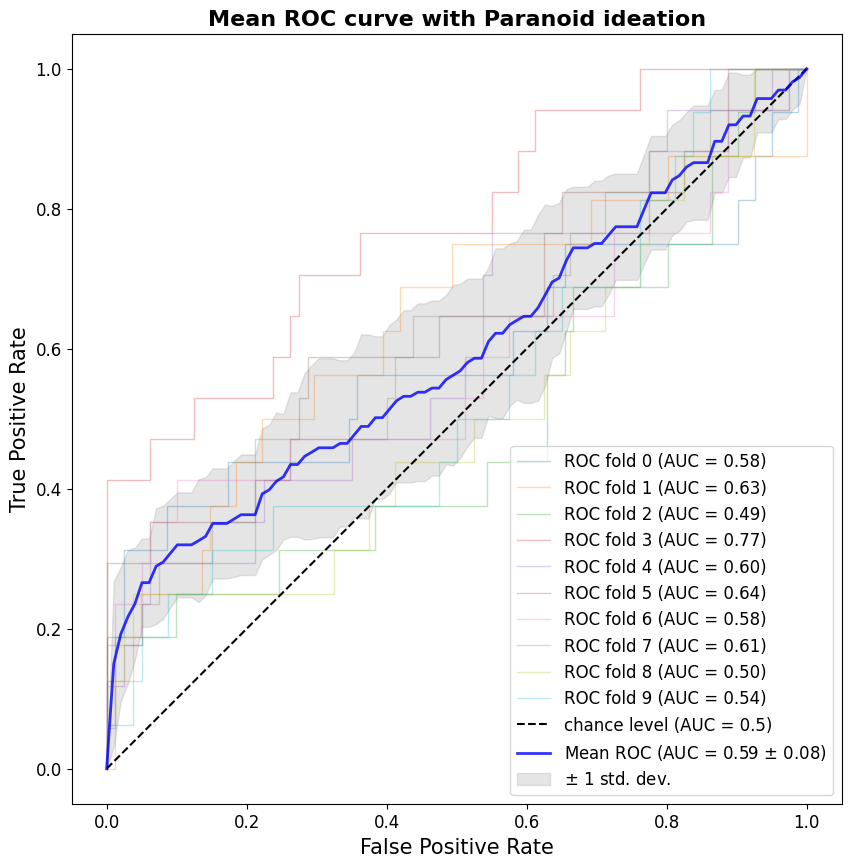

Max score: 0.8865979381443299
Min score: 0.8541666666666666
Max score: 0.8692051485390105
Min score: 0.8033205619412517
Avg score: 0.8708440721649484
Avg F1-score: 0.835941582211435


In [147]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Test
class EmbraceNet(nn.Module):
  
  def __init__(self, device, modality_indices, input_size_list, embracement_size=256, bypass_docking=False):
    """
    Initialize an EmbraceNet module.
    Args:
      device: A "torch.device()" object to allocate internal parameters of the EmbraceNet module.
      input_size_list: A list of input sizes.
      embracement_size: The length of the output of the embracement layer ("c" in the paper).
      bypass_docking: Bypass docking step, i.e., connect the input data directly to the embracement layer. If True, input_data must have a shape of [batch_size, embracement_size].
    """
    super(EmbraceNet, self).__init__()

    self.device = device
    self.input_size_list = input_size_list
    self.embracement_size = embracement_size
    self.bypass_docking = bypass_docking
    self.modality_indices = modality_indices
  
    if (not bypass_docking):
      for i, input_size in enumerate(input_size_list):
        # setattr(self, 'project_%d' % (i), nn.Linear(input_size, embracement_size ))
        setattr(self, 'docking_%d' % (i), nn.Linear(input_size , embracement_size))

  def forward(self, input_list, availabilities=None, selection_probabilities=None):
    """
    Forward input data to the EmbraceNet module.
    Args:
      input_list: A list of input data. Each input data should have a size as in input_size_list.
      availabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents the availability of data for each modality. If None, it assumes that data of all modalities are available.
      selection_probabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents probabilities that output of each docking layer will be selected ("p" in the paper). If None, the same probability of being selected will be used for each docking layer.
    Returns:
      A 2-D tensor of shape [batch_size, embracement_size] that is the embraced output.
    """

    # check input data
    assert len(input_list) == len(self.input_size_list)
    num_modalities = len(input_list)
    batch_size = input_list[0].shape[0]
    
    # docking layer
    docking_output_list = []
    if (self.bypass_docking):
      docking_output_list = input_list
    else:
      for i, input_data in enumerate(input_list):
        # x = getattr(self, 'project_%d' % (i))(input_data)
        x = getattr(self, 'docking_%d' % (i))(input_data)
         
        x = nn.functional.relu(x)
        docking_output_list.append(x)

    # check availabilities
    if (availabilities is None):
      availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    else:
      availabilities = availabilities.float()
    
    # adjust selection probabilities
    if (selection_probabilities is None):
      selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    selection_probabilities = torch.mul(selection_probabilities, availabilities)
    
    probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
    selection_probabilities = torch.div(selection_probabilities, probability_sum)
    # stack docking outputs
    docking_output_stack = torch.stack(docking_output_list, dim=-1)  # [batch_size, embracement_size, num_modalities]
    
#     print("Batch size:",batch_size)
    # embrace
#     modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)  # [batch_size, embracement_size]
#     print( self.modality_indices)
    modality_toggles = nn.functional.one_hot( self.modality_indices, num_classes=num_modalities).float()  # [batch_size, embracement_size, num_modalities]

    embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
#     print(modality_toggles.cpu().detach().numpy()[0,:,:])
#     print(modality_toggles.cpu().detach().numpy()[1,:,:])
    embracement_output = torch.sum(embracement_output_stack, dim=-1)  # [batch_size, embracement_size]
    return embracement_output, modality_toggles.cpu().detach().numpy()


class EmbraceTextAudioVideo(nn.Module):
    def __init__(self, device, modality_indices, input_size, embrace_size):
        super(EmbraceTextAudioVideo, self).__init__()

        self.device = device
        # embracenet
        self.embracenet = EmbraceNet(device=self.device, modality_indices = modality_indices, input_size_list=input_size, embracement_size=embrace_size)

        # post embracement layers
        self.post = nn.Linear(in_features=embrace_size, out_features=2)

        # self.acti = nn.Tanhshrink()
        # self.acti = nn.Hardtanh()
        # self.acti = nn.ELU()
        # self.acti = nn.Softsign()
        # self.acti = nn.LogSigmoid()
        # self.acti = nn.Tanh()

    def forward(self, roberta, pert, wav, wav2vec, iris, physical_index, face, face_vari, att, graph):
        embraced_output, factor = self.embracenet(input_list=[face, face_vari, iris, wav, wav2vec, physical_index, roberta, pert, att, graph])

        # embraced_output = self.embracenet(input_list=[roberta, pert, macbert, wav, iris, physical_index])
        x = self.post(embraced_output)
        # print(x)
        x = torch.sigmoid(x)
        # x = torch.relu(x)
        # x = torch.rrelu(x)
        # x = torch.selu(x)
        # x = torch.celu(x)
        # x = self.acti(x)
        return x, factor

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
total_acc = []
total_f1 = []

if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        ltype = torch.cuda.LongTensor
else:
        dtype = torch.FloatTensor
        ltype = torch.LongTensor

for j in range(0, 1):
        ACC = []
        F1 = []
        contri = []
        for i in range(0, 10):
                print("The {round} group of {time}".format(round=i, time = j))

                face_x_train, face_y_train = face_x_train_skf[i], face_y_train_skf[i]
                face_vari_x_train, face_vari_y_train = face_vari_x_train_skf[i], face_vari_y_train_skf[i]
                iris_x_train, iris_y_train = iris_x_train_skf[i], iris_y_train_skf[i]
                physical_x_train, physical_y_train = physical_x_train_skf[i], \
                        physical_y_train_skf[i]
                mfcc_ft_x_train, mfcc_ft_y_train = mfcc_ft_x_train_skf[i], mfcc_ft_y_train_skf[i]
                wav2vec_x_train, wav2vec_y_train = wav2vec_x_train_skf[i], wav2vec_y_train_skf[i]
                pert_x_train, pert_y_train = pert_x_train_skf[i], pert_y_train_skf[i]
                roberta_x_train, roberta_y_train = roberta_x_train_skf[i], roberta_y_train_skf[i]
                att_x_train, att_y_train = att_x_train_skf[i], att_y_train_skf[i]
                graph_x_train, graph_y_train = graph_x_train_skf[i], graph_y_train_skf[i]

                face_x_train, face_x_test, face_y_train, face_y_test = np.array(face_x_train), np.array(face_x_test_skf[i]),\
                        np.array(face_y_train), np.array(face_y_test_skf[i])
                face_vari_x_train, face_vari_x_test, face_vari_y_train, face_vari_y_test = np.array(face_vari_x_train), np.array(face_vari_x_test_skf[i]),\
                        np.array(face_vari_y_train), np.array(face_vari_y_test_skf[i])
                iris_x_train, iris_x_test, iris_y_train, iris_y_test = np.array(iris_x_train), np.array(iris_x_test_skf[i]),\
                        np.array(iris_y_train), np.array(iris_y_test_skf[i])
                physical_index_x_train, physical_index_x_test, physical_index_y_train, physical_index_y_test = \
                        np.array(physical_x_train), np.array(physical_x_test_skf[i]), np.array(physical_y_train), np.array(physical_y_test_skf[i])
                wav2vec_x_train, wav2vec_x_test, wav2vec_y_train, wav2vec_y_test = np.array(wav2vec_x_train), \
                        np.array(wav2vec_x_test_skf[i]), np.array(wav2vec_y_train), np.array(wav2vec_y_test_skf[i])
                mfcc_ft_x_train, mfcc_ft_x_test, mfcc_ft_y_train, mfcc_ft_y_test = np.array(mfcc_ft_x_train), \
                        np.array(mfcc_ft_x_test_skf[i]), np.array(mfcc_ft_y_train), np.array(mfcc_ft_y_test_skf[i])
                pert_x_train, pert_x_test, pert_y_train, pert_y_test = np.array(pert_x_train), np.array(pert_x_test_skf[i]),\
                        np.array(pert_y_train), np.array(pert_y_test_skf[i])
                roberta_x_train, roberta_x_test, roberta_y_train, roberta_y_test = np.array(roberta_x_train), np.array(roberta_x_test_skf[i]),\
                        np.array(roberta_y_train), np.array(roberta_y_test_skf[i])
                att_x_train, att_x_test, att_y_train, att_y_test = np.array(att_x_train), np.array(att_x_test_skf[i]),\
                        np.array(att_y_train), np.array(att_y_test_skf[i])
                graph_x_train, graph_x_test, graph_y_train, graph_y_test = np.array(graph_x_train), np.array(graph_x_test_skf[i]),\
                        np.array(graph_y_train), np.array(graph_y_test_skf[i])

                pert_x_train, pert_y_train = torch.from_numpy(pert_x_train).type(dtype), \
                        torch.from_numpy(pert_y_train).type(ltype)
                roberta_x_train, roberta_y_train = torch.from_numpy(roberta_x_train).type(dtype), \
                        torch.from_numpy(roberta_y_train).type(ltype)
                wav2vec_x_train, wav2vec_y_train = torch.from_numpy(wav2vec_x_train).type(dtype), \
                        torch.from_numpy(wav2vec_y_train).type(ltype)
                mfcc_ft_x_train, mfcc_ft_y_train = torch.from_numpy(mfcc_ft_x_train).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_train).type(ltype)
                face_x_train, face_y_train = torch.from_numpy(face_x_train).type(dtype), \
                        torch.from_numpy(face_y_train).type(ltype)
                face_vari_x_train, face_vari_y_train = torch.from_numpy(face_vari_x_train).type(dtype), \
                        torch.from_numpy(face_vari_y_train).type(ltype)
                iris_x_train, iris_y_train = torch.from_numpy(iris_x_train).type(dtype), \
                        torch.from_numpy(iris_y_train).type(ltype)
                physical_index_x_train, physical_index_y_train = torch.from_numpy(physical_index_x_train).type(dtype), \
                        torch.from_numpy(physical_index_y_train).type(ltype)
                att_x_train, att_y_train = torch.from_numpy(att_x_train).type(dtype), \
                        torch.from_numpy(att_y_train).type(ltype)
                graph_x_train, graph_y_train = torch.from_numpy(graph_x_train).type(dtype), \
                        torch.from_numpy(graph_y_train).type(ltype)

                pert_x_test, pert_y_test = torch.from_numpy(pert_x_test).type(dtype), \
                        torch.from_numpy(pert_y_test).type(ltype)
                roberta_x_test, roberta_y_test = torch.from_numpy(roberta_x_test).type(dtype), \
                        torch.from_numpy(roberta_y_test).type(ltype)
                wav2vec_x_test, wav2vec_y_test = torch.from_numpy(wav2vec_x_test).type(dtype), \
                        torch.from_numpy(wav2vec_y_test).type(ltype)
                mfcc_ft_x_test, mfcc_ft_y_test = torch.from_numpy(mfcc_ft_x_test).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_test).type(ltype)
                face_x_test, face_y_test = torch.from_numpy(face_x_test).type(dtype), \
                        torch.from_numpy(face_y_test).type(ltype)
                face_vari_x_test, face_vari_y_test = torch.from_numpy(face_vari_x_test).type(dtype), \
                        torch.from_numpy(face_vari_y_test).type(ltype)
                iris_x_test, iris_y_test = torch.from_numpy(iris_x_test).type(dtype), \
                        torch.from_numpy(iris_y_test).type(ltype)
                physical_index_x_test, physical_index_y_test = torch.from_numpy(physical_index_x_test).type(dtype), \
                        torch.from_numpy(physical_index_y_test).type(ltype)
                att_x_test, att_y_test = torch.from_numpy(att_x_test).type(dtype), \
                        torch.from_numpy(att_y_test).type(ltype)
                graph_x_test, graph_y_test = torch.from_numpy(graph_x_test).type(dtype), \
                        torch.from_numpy(graph_y_test).type(ltype)
                y_train = pert_y_train
                y_test = pert_y_test

                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                print(device)
                files = os.listdir('./Result/paranoia/')
                for detail in files:
                        # print('./checkpoint/final/' + detail)
                        pt_name = 'Round_' + str(i)
                        if pt_name in detail and 'indices' in detail:
                                pt_path = './Result/paranoia/' + detail
                                print(pt_path)
                                load_indices = torch.load(pt_path, map_location="cpu")
                                model = EmbraceTextAudioVideo(device, load_indices, [1404, 1404, 2776, 12987, 1024, 4722, 1024, 1024, 26365, 64], 32)

                for detail in files:
                        # print('./checkpoint/final/' + detail)
                        pt_name = 'Round_' + str(i)
                        if pt_name in detail and '.pth' in detail:
                                pt_path = './Result/paranoia/' + detail
                                print(pt_path)
                                m_state_dict  = torch.load(pt_path, map_location=device)
                                model.load_state_dict(m_state_dict)
                                # print("//////////////////////////////////////////////////////")
                                # for parameters in model.parameters():
                                #         print(parameters)
                                # print("Model's state_dict:")
                                # for param_tensor in model.state_dict():
                                #         print(param_tensor, "\t", model.state_dict()[param_tensor].size())
                                # model.train(False
                model.to(device)
                out, factor = model(roberta_x_test, pert_x_test ,mfcc_ft_x_test, wav2vec_x_test, iris_x_test, 
                                        physical_index_x_test, face_x_test, face_vari_x_test, att_x_test, graph_x_test)
                # out = model.forward(roberta_x_test, pert_x_test ,mfcc_ft_x_test, wav2vec_x_test, \
                #                         iris_x_test, physical_index_x_test, face_x_test, face_vari_x_test, graph_x_test)
                model.eval()
                # print(roberta_x_test[0])

                # print(factor.shape)      
                # factor_value =  np.sum(factor, axis=0)
                # print(factor_value)
                # factor_value =  np.sum(factor_value, axis=0)
                # print(factor_value)
                # print(np.sum(factor_value))
                # contri.append(factor_value)

                prediction = []
                scores = []
                weights = []
                for item in out:
                        scores.append(item[1].detach().numpy())
                        if item[0] > item[1]:
                                weights.append(true_ratio)
                                prediction.append(0)
                        else:
                                weights.append(false_ratio)
                                prediction.append(1)
                                
                        
                pred_y = np.array(prediction)
                scores_y = np.array(scores)
                print(pred_y)
                
                target_y = y_test.cpu().data.numpy()
                test_score = accuracy_score(target_y, pred_y)
                test_f1 = f1_score(target_y, pred_y, average='weighted')
                print('The acc: {acc} and f1 score:{f1}'.format(acc=test_score,f1=test_f1))
                print(target_y)
                fpr, tpr, thresholds = metrics.roc_curve(target_y, scores_y * true_ratio)
                # fpr = fpr * false_ratio
                # tpr = tpr * true_ratio
                print(fpr, tpr)
                auc = metrics.auc(fpr, tpr)
                print(auc)

                ACC.append(test_score)
                F1.append(test_f1)

                # print(target_y)
                # print(pred_y)
                

                viz = RocCurveDisplay.from_predictions(
                        target_y,
                        scores_y,
                        name=f"ROC fold {i}",
                        alpha=0.3,
                        lw=1,
                        ax=ax,
                )
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)
        
        ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(
                        mean_fpr,
                        mean_tpr,
                        color="b",
                        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
                        lw=2,
                        alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
                        mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color="grey",
                        alpha=0.2,
                        label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
                        xlim=[-0.05, 1.05],
                        ylim=[-0.05, 1.05],
        )
        ax.axis("square")
        ax.legend(loc="lower right", fontsize='large')

        ax.set_xlabel("False Positive Rate", fontsize=15)
        ax.set_ylabel("True Positive Rate", fontsize=15)
        ax.set_title(f"Mean ROC curve with Paranoid ideation", fontsize=16, fontweight='semibold')
        plt.savefig('./roc.pdf', dpi=300)
        plt.show()
        

        print("Max score:", np.max(ACC))
        print("Min score:", np.min(ACC))
        
        print("Max score:", np.max(F1))
        print("Min score:", np.min(F1))

        print("Avg score:", np.mean(ACC))
        print("Avg F1-score:", np.mean(F1))
        # print(np.sum(contri, axis=0) / np.sum(np.sum(contri, axis=0)))
        # print( np.sum(np.sum(contri, axis=0)))



In [250]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
# Test
class EmbraceNet(nn.Module):
  
  def __init__(self, device, modality_indices, input_size_list, embracement_size=256, bypass_docking=False):
    """
    Initialize an EmbraceNet module.
    Args:
      device: A "torch.device()" object to allocate internal parameters of the EmbraceNet module.
      input_size_list: A list of input sizes.
      embracement_size: The length of the output of the embracement layer ("c" in the paper).
      bypass_docking: Bypass docking step, i.e., connect the input data directly to the embracement layer. If True, input_data must have a shape of [batch_size, embracement_size].
    """
    super(EmbraceNet, self).__init__()

    self.device = device
    self.input_size_list = input_size_list
    self.embracement_size = embracement_size
    self.bypass_docking = bypass_docking
    self.modality_indices = modality_indices
  
    if (not bypass_docking):
      for i, input_size in enumerate(input_size_list):
        # setattr(self, 'project_%d' % (i), nn.Linear(input_size, embracement_size ))
        setattr(self, 'docking_%d' % (i), nn.Linear(input_size , embracement_size))

  def forward(self, input_list, availabilities=None, selection_probabilities=None):
    """
    Forward input data to the EmbraceNet module.
    Args:
      input_list: A list of input data. Each input data should have a size as in input_size_list.
      availabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents the availability of data for each modality. If None, it assumes that data of all modalities are available.
      selection_probabilities: A 2-D tensor of shape [batch_size, num_modalities], which represents probabilities that output of each docking layer will be selected ("p" in the paper). If None, the same probability of being selected will be used for each docking layer.
    Returns:
      A 2-D tensor of shape [batch_size, embracement_size] that is the embraced output.
    """

    # check input data
    assert len(input_list) == len(self.input_size_list)
    num_modalities = len(input_list)
    batch_size = input_list[0].shape[0]
    
    # docking layer
    docking_output_list = []
    if (self.bypass_docking):
      docking_output_list = input_list
    else:
      for i, input_data in enumerate(input_list):
        # x = getattr(self, 'project_%d' % (i))(input_data)
        x = getattr(self, 'docking_%d' % (i))(input_data)
         
        x = nn.functional.relu(x)
        docking_output_list.append(x)

    # check availabilities
    if (availabilities is None):
      availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    else:
      availabilities = availabilities.float()
    
    # adjust selection probabilities
    if (selection_probabilities is None):
      selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.device)
    selection_probabilities = torch.mul(selection_probabilities, availabilities)
    
    probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
    selection_probabilities = torch.div(selection_probabilities, probability_sum)
    # stack docking outputs
    docking_output_stack = torch.stack(docking_output_list, dim=-1)  # [batch_size, embracement_size, num_modalities]
    
#     print("Batch size:",batch_size)
    # embrace
#     modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)  # [batch_size, embracement_size]
#     print( self.modality_indices)
    modality_toggles = nn.functional.one_hot( self.modality_indices, num_classes=num_modalities).float()  # [batch_size, embracement_size, num_modalities]

    embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
#     print(modality_toggles.cpu().detach().numpy()[0,:,:])
#     print(modality_toggles.cpu().detach().numpy()[1,:,:])
    embracement_output = torch.sum(embracement_output_stack, dim=-1)  # [batch_size, embracement_size]
    return embracement_output, modality_toggles.cpu().detach().numpy()


class EmbraceTextAudioVideo(nn.Module):
    def __init__(self, device, modality_indices, input_size, embrace_size):
        super(EmbraceTextAudioVideo, self).__init__()

        self.device = device
        # embracenet
        self.embracenet = EmbraceNet(device=self.device, modality_indices = modality_indices, input_size_list=input_size, embracement_size=embrace_size)

        # post embracement layers
        self.post = nn.Linear(in_features=embrace_size, out_features=2)

        # self.acti = nn.Tanhshrink()
        # self.acti = nn.Hardtanh()
        # self.acti = nn.ELU()
        # self.acti = nn.Softsign()
        # self.acti = nn.LogSigmoid()
        # self.acti = nn.Tanh()

    def forward(self, roberta, pert, wav, wav2vec, iris, physical_index, face, face_vari, att, graph):
        embraced_output, factor = self.embracenet(input_list=[face, face_vari, iris, wav, wav2vec, physical_index, roberta, pert, att, graph])

        # embraced_output = self.embracenet(input_list=[roberta, pert, macbert, wav, iris, physical_index])
        x = self.post(embraced_output)
        # print(x)
        x = torch.sigmoid(x)
        # x = torch.relu(x)
        # x = torch.rrelu(x)
        # x = torch.selu(x)
        # x = torch.celu(x)
        # x = self.acti(x)
        return x, factor

cv = StratifiedKFold(n_splits=10)
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)
# fig, ax = plt.subplots(figsize=(10,10))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
total_acc = []
total_f1 = []
confs = []

rs = []
ps = []

if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        ltype = torch.cuda.LongTensor
else:
        dtype = torch.FloatTensor
        ltype = torch.LongTensor

for j in range(0, 1):
        ACC = []
        F1 = []
        contri = []
        for i in range(0, 10):
                print("The {round} group of {time}".format(round=i, time = j))

                face_x_train, face_y_train = face_x_train_skf[i], face_y_train_skf[i]
                face_vari_x_train, face_vari_y_train = face_vari_x_train_skf[i], face_vari_y_train_skf[i]
                iris_x_train, iris_y_train = iris_x_train_skf[i], iris_y_train_skf[i]
                physical_x_train, physical_y_train = physical_x_train_skf[i], \
                        physical_y_train_skf[i]
                mfcc_ft_x_train, mfcc_ft_y_train = mfcc_ft_x_train_skf[i], mfcc_ft_y_train_skf[i]
                wav2vec_x_train, wav2vec_y_train = wav2vec_x_train_skf[i], wav2vec_y_train_skf[i]
                pert_x_train, pert_y_train = pert_x_train_skf[i], pert_y_train_skf[i]
                roberta_x_train, roberta_y_train = roberta_x_train_skf[i], roberta_y_train_skf[i]
                att_x_train, att_y_train = att_x_train_skf[i], att_y_train_skf[i]
                graph_x_train, graph_y_train = graph_x_train_skf[i], graph_y_train_skf[i]

                face_x_train, face_x_test, face_y_train, face_y_test = np.array(face_x_train), np.array(face_x_test_skf[i]),\
                        np.array(face_y_train), np.array(face_y_test_skf[i])
                face_vari_x_train, face_vari_x_test, face_vari_y_train, face_vari_y_test = np.array(face_vari_x_train), np.array(face_vari_x_test_skf[i]),\
                        np.array(face_vari_y_train), np.array(face_vari_y_test_skf[i])
                iris_x_train, iris_x_test, iris_y_train, iris_y_test = np.array(iris_x_train), np.array(iris_x_test_skf[i]),\
                        np.array(iris_y_train), np.array(iris_y_test_skf[i])
                physical_index_x_train, physical_index_x_test, physical_index_y_train, physical_index_y_test = \
                        np.array(physical_x_train), np.array(physical_x_test_skf[i]), np.array(physical_y_train), np.array(physical_y_test_skf[i])
                wav2vec_x_train, wav2vec_x_test, wav2vec_y_train, wav2vec_y_test = np.array(wav2vec_x_train), \
                        np.array(wav2vec_x_test_skf[i]), np.array(wav2vec_y_train), np.array(wav2vec_y_test_skf[i])
                mfcc_ft_x_train, mfcc_ft_x_test, mfcc_ft_y_train, mfcc_ft_y_test = np.array(mfcc_ft_x_train), \
                        np.array(mfcc_ft_x_test_skf[i]), np.array(mfcc_ft_y_train), np.array(mfcc_ft_y_test_skf[i])
                pert_x_train, pert_x_test, pert_y_train, pert_y_test = np.array(pert_x_train), np.array(pert_x_test_skf[i]),\
                        np.array(pert_y_train), np.array(pert_y_test_skf[i])
                roberta_x_train, roberta_x_test, roberta_y_train, roberta_y_test = np.array(roberta_x_train), np.array(roberta_x_test_skf[i]),\
                        np.array(roberta_y_train), np.array(roberta_y_test_skf[i])
                att_x_train, att_x_test, att_y_train, att_y_test = np.array(att_x_train), np.array(att_x_test_skf[i]),\
                        np.array(att_y_train), np.array(att_y_test_skf[i])
                graph_x_train, graph_x_test, graph_y_train, graph_y_test = np.array(graph_x_train), np.array(graph_x_test_skf[i]),\
                        np.array(graph_y_train), np.array(graph_y_test_skf[i])

                pert_x_train, pert_y_train = torch.from_numpy(pert_x_train).type(dtype), \
                        torch.from_numpy(pert_y_train).type(ltype)
                roberta_x_train, roberta_y_train = torch.from_numpy(roberta_x_train).type(dtype), \
                        torch.from_numpy(roberta_y_train).type(ltype)
                wav2vec_x_train, wav2vec_y_train = torch.from_numpy(wav2vec_x_train).type(dtype), \
                        torch.from_numpy(wav2vec_y_train).type(ltype)
                mfcc_ft_x_train, mfcc_ft_y_train = torch.from_numpy(mfcc_ft_x_train).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_train).type(ltype)
                face_x_train, face_y_train = torch.from_numpy(face_x_train).type(dtype), \
                        torch.from_numpy(face_y_train).type(ltype)
                face_vari_x_train, face_vari_y_train = torch.from_numpy(face_vari_x_train).type(dtype), \
                        torch.from_numpy(face_vari_y_train).type(ltype)
                iris_x_train, iris_y_train = torch.from_numpy(iris_x_train).type(dtype), \
                        torch.from_numpy(iris_y_train).type(ltype)
                physical_index_x_train, physical_index_y_train = torch.from_numpy(physical_index_x_train).type(dtype), \
                        torch.from_numpy(physical_index_y_train).type(ltype)
                att_x_train, att_y_train = torch.from_numpy(att_x_train).type(dtype), \
                        torch.from_numpy(att_y_train).type(ltype)
                graph_x_train, graph_y_train = torch.from_numpy(graph_x_train).type(dtype), \
                        torch.from_numpy(graph_y_train).type(ltype)

                pert_x_test, pert_y_test = torch.from_numpy(pert_x_test).type(dtype), \
                        torch.from_numpy(pert_y_test).type(ltype)
                roberta_x_test, roberta_y_test = torch.from_numpy(roberta_x_test).type(dtype), \
                        torch.from_numpy(roberta_y_test).type(ltype)
                wav2vec_x_test, wav2vec_y_test = torch.from_numpy(wav2vec_x_test).type(dtype), \
                        torch.from_numpy(wav2vec_y_test).type(ltype)
                mfcc_ft_x_test, mfcc_ft_y_test = torch.from_numpy(mfcc_ft_x_test).type(dtype), \
                        torch.from_numpy(mfcc_ft_y_test).type(ltype)
                face_x_test, face_y_test = torch.from_numpy(face_x_test).type(dtype), \
                        torch.from_numpy(face_y_test).type(ltype)
                face_vari_x_test, face_vari_y_test = torch.from_numpy(face_vari_x_test).type(dtype), \
                        torch.from_numpy(face_vari_y_test).type(ltype)
                iris_x_test, iris_y_test = torch.from_numpy(iris_x_test).type(dtype), \
                        torch.from_numpy(iris_y_test).type(ltype)
                physical_index_x_test, physical_index_y_test = torch.from_numpy(physical_index_x_test).type(dtype), \
                        torch.from_numpy(physical_index_y_test).type(ltype)
                att_x_test, att_y_test = torch.from_numpy(att_x_test).type(dtype), \
                        torch.from_numpy(att_y_test).type(ltype)
                graph_x_test, graph_y_test = torch.from_numpy(graph_x_test).type(dtype), \
                        torch.from_numpy(graph_y_test).type(ltype)
                y_train = pert_y_train
                y_test = pert_y_test

                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                print(device)
                files = os.listdir('./Result/suicide/')
                for detail in files:
                        # print('./checkpoint/final/' + detail)
                        pt_name = 'Round_' + str(i)
                        if pt_name in detail and 'indices' in detail:
                                pt_path = './Result/suicide/' + detail
                                print(pt_path)
                                load_indices = torch.load(pt_path, map_location="cpu")
                                model = EmbraceTextAudioVideo(device, load_indices, [1404, 1404, 2776, 12987, 1024, 4722, 1024, 1024, 26365, 64], 32)

                for detail in files:
                        # print('./checkpoint/final/' + detail)
                        pt_name = 'Round_' + str(i)
                        if pt_name in detail and '.pth' in detail:
                                pt_path = './Result/suicide/' + detail
                                print(pt_path)
                                m_state_dict  = torch.load(pt_path, map_location=device)
                                model.load_state_dict(m_state_dict)
                                # print("//////////////////////////////////////////////////////")
                                # for parameters in model.parameters():
                                #         print(parameters)
                                # print("Model's state_dict:")
                                # for param_tensor in model.state_dict():
                                #         print(param_tensor, "\t", model.state_dict()[param_tensor].size())
                                # model.train(False
                model.to(device)
                out, factor = model(roberta_x_test, pert_x_test ,mfcc_ft_x_test, wav2vec_x_test, iris_x_test, 
                                        physical_index_x_test, face_x_test, face_vari_x_test, att_x_test, graph_x_test)
                # out = model.forward(roberta_x_test, pert_x_test ,mfcc_ft_x_test, wav2vec_x_test, \
                #                         iris_x_test, physical_index_x_test, face_x_test, face_vari_x_test, graph_x_test)
                model.eval()
                # print(roberta_x_test[0])

                # print(factor.shape)      
                # factor_value =  np.sum(factor, axis=0)
                # print(factor_value)
                # factor_value =  np.sum(factor_value, axis=0)
                # print(factor_value)
                # print(np.sum(factor_value))
                # contri.append(factor_value)
                weights = []
                prediction = []
                scores = []
                for item in out:
                        scores.append(item[1].detach().numpy())
                        if item[0] > item[1]:
                                weights.append(1/false_ratio)
                                prediction.append(0)
                        else:
                                weights.append(1/true_ratio)
                                prediction.append(1)
                                
                        
                pred_y = np.array(prediction)
                scores_y = np.array(scores)
                # print(pred_y)
                
                target_y = y_test.cpu().data.numpy()
                test_score = accuracy_score(target_y, pred_y)
                test_f1 = f1_score(target_y, pred_y, average='weighted')
                print('The acc: {acc} and f1 score:{f1}'.format(acc=test_score,f1=test_f1))
                # print(target_y)
                recall = recall_score(target_y, pred_y, average='weighted')
                precision = precision_score(target_y, pred_y, average='weighted')
                print(recall, precision)
                rs.append(recall)
                ps.append(precision)
                conf_mat = confusion_matrix(target_y, pred_y)
                print(conf_mat.reshape(1,-1)[0].tolist())
                
                confs.append(conf_mat.reshape(1,-1)[0].tolist())

                ACC.append(test_score)
                F1.append(test_f1)

                # print(target_y)
                # print(pred_y)

        print("Max score:", np.max(ACC))
        print("Min score:", np.min(ACC))
        
        print("Max score:", np.max(F1))
        print("Min score:", np.min(F1))

        print("Avg score:", np.mean(ACC))
        print("Avg F1-score:", np.mean(F1))
        # print(np.sum(contri, axis=0) / np.sum(np.sum(contri, axis=0)))
        # print( np.sum(np.sum(contri, axis=0)))



The 0 group of 0
cpu
./Result/suicide/Round_0_indices.pt
./Result/suicide/Round_0_8351.pth
The acc: 0.8350515463917526 and f1 score:0.7827423116322662
0.8350515463917526 0.863127878920816
[78, 0, 16, 3]
The 1 group of 0
cpu
./Result/suicide/Round_1_indices.pt
./Result/suicide/Round_1_8351.pth
The acc: 0.8350515463917526 and f1 score:0.7827423116322662
0.8350515463917526 0.863127878920816
[78, 0, 16, 3]
The 2 group of 0
cpu
./Result/suicide/Round_2_indices.pt
./Result/suicide/Round_2_8660.pth
The acc: 0.865979381443299 and f1 score:0.8362886597938145
0.865979381443299 0.8851251840942561
[78, 0, 13, 6]
The 3 group of 0
cpu
./Result/suicide/Round_3_indices.pt
./Result/suicide/Round_3_8866.pth
The acc: 0.8865979381443299 and f1 score:0.8672323165810418
0.8865979381443299 0.9006139233175027
[78, 0, 11, 8]
The 4 group of 0
cpu
./Result/suicide/Round_4_indices.pt
./Result/suicide/Round_4_8454.pth
The acc: 0.845360824742268 and f1 score:0.8271823822124655
0.845360824742268 0.8330027680303393
[

In [206]:
total_rs = []
total_ps = []
total_confs = []


In [251]:
total_rs.append(rs)
total_ps.append(ps)
total_confs.append(confs)

print(total_rs)
print(total_ps)
print(total_confs)
print(np.array(total_confs).shape)



[[0.8865979381443299, 0.8865979381443299, 0.8865979381443299, 0.9278350515463918, 0.8762886597938144, 0.9072164948453608, 0.8762886597938144, 0.8865979381443299, 0.8958333333333334, 0.8958333333333334], [0.7938144329896907, 0.8041237113402062, 0.8041237113402062, 0.8247422680412371, 0.7938144329896907, 0.7938144329896907, 0.8144329896907216, 0.8144329896907216, 0.78125, 0.7916666666666666], [0.865979381443299, 0.8556701030927835, 0.8350515463917526, 0.8762886597938144, 0.8350515463917526, 0.8556701030927835, 0.8556701030927835, 0.8865979381443299, 0.8854166666666666, 0.8333333333333334], [0.7628865979381443, 0.7835051546391752, 0.7628865979381443, 0.7938144329896907, 0.7835051546391752, 0.7731958762886598, 0.7525773195876289, 0.7731958762886598, 0.7708333333333334, 0.8020833333333334], [0.7422680412371134, 0.7010309278350515, 0.711340206185567, 0.7319587628865979, 0.7216494845360825, 0.711340206185567, 0.7422680412371134, 0.7422680412371134, 0.7604166666666666, 0.7395833333333334], [0.

In [262]:
import pandas as pd
df_rs = pd.DataFrame(data=np.array(total_rs).T)
df_ps = pd.DataFrame(data=np.array(total_ps).T)
# print(df_rs)
print(df_ps)
df_rs.to_csv('./Total_recall.csv')
df_ps.to_csv('./Total_precision.csv')

         0         1         2         3         4         5         6   \
0  0.900157  0.839130  0.885125  0.775103  0.746144  0.892251  0.877166   
1  0.900157  0.820499  0.855866  0.780450  0.692761  0.884514  0.892425   
2  0.900157  0.794627  0.829718  0.775103  0.703997  0.892251  0.892425   
3  0.933575  0.858599  0.892784  0.790474  0.726112  0.885425  0.892602   
4  0.874161  0.810234  0.829718  0.796184  0.722774  0.877166  0.884917   
5  0.906636  0.810234  0.877633  0.775609  0.724682  0.892425  0.892602   
6  0.874161  0.817546  0.877633  0.745196  0.755014  0.892425  0.829341   
7  0.880370  0.819720  0.900614  0.829260  0.755014  0.892425  0.892602   
8  0.889147  0.780572  0.899740  0.759722  0.757850  0.883513  0.899421   
9  0.907407  0.778646  0.817282  0.803776  0.739503  0.875887  0.868684   

         7         8         9         10        11  
0  0.750161  0.907875  0.792955  0.924471  0.863128  
1  0.694355  0.907875  0.835169  0.924471  0.863128  
2  0.702654 

In [269]:
df_confs = pd.DataFrame(data=np.array(total_confs).reshape(12, 40).T)
print(df_confs)
df_confs.to_csv('./Total_confs.csv')

    0   1   2   3   4   5   6   7   8   9   10  11
0   81  71  78  65  56  81  80  50  84  66  87  78
1    0   0   0   2   5   0   0  11   0   1   0   0
2   11  20  13  21  20  12  14  13  10  22   8  16
3    5   6   6   9  16   4   3  23   3   8   2   3
4   81  70  77  63  50  81  80  49  84  67  87  78
5    0   1   1   4  11   0   0  12   0   0   0   0
6   11  18  13  17  18  13  12  17  10  21   8  16
7    5   8   6  13  18   3   5  19   3   9   2   3
8   81  67  77  65  53  81  80  45  84  63  86  78
9    0   4   1   2   8   0   0  15   0   4   1   0
10  11  15  15  21  20  12  12  14   9  23   6  13
11   5  11   4   9  16   4   5  23   4   7   4   6
12  81  71  78  58  51  79  79  59  84  67  87  78
13   0   0   0   9  10   1   0   1   0   0   0   0
14   7  17  12  11  16  10  12  20  10  22   7  11
15   9   9   7  19  20   7   6  17   3   8   3   8
16  79  70  77  65  54  80  79  51  81  67  87  74
17   1   1   1   2   6   0   0   9   3   0   0   3
18  11  19  15  19  21  14  13 

In [27]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
df_rs = pd.read_csv('./Total_recall.csv')
print(df_rs)

   Overall health status  Depression  Interpersonal sensitivity   Anxiety  \
0               0.886598    0.793814                   0.865979  0.762887   
1               0.886598    0.804124                   0.855670  0.783505   
2               0.886598    0.804124                   0.835052  0.762887   
3               0.927835    0.824742                   0.876289  0.793814   
4               0.876289    0.793814                   0.835052  0.783505   
5               0.907216    0.793814                   0.855670  0.773196   
6               0.876289    0.814433                   0.855670  0.752577   
7               0.886598    0.814433                   0.886598  0.773196   
8               0.895833    0.781250                   0.885417  0.770833   
9               0.895833    0.791667                   0.833333  0.802083   

   Obsessive-compulsive tendencies  Paranoid ideation  Hostility  \
0                         0.742268           0.876289   0.855670   
1               

<Axes: >

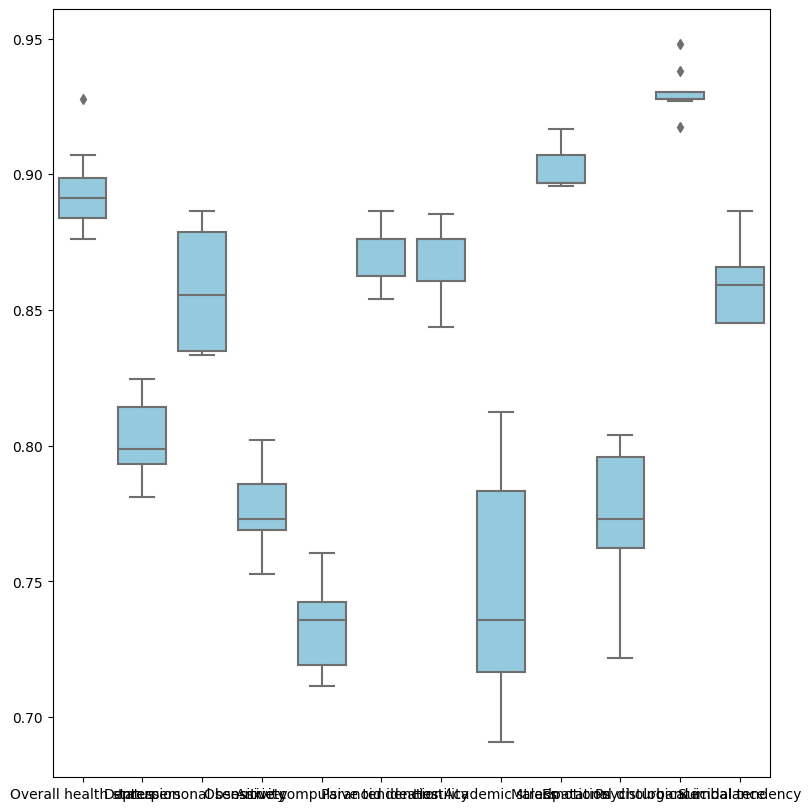

In [31]:
f, ax = plt.subplots(figsize=(8,8),constrained_layout=True)
sns.boxplot(data=df_rs.iloc[2:12], color="skyblue", ax=ax)